# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Вам нужно научиться определять рыночную стоимость объектов недвижимости. Для этого проведите исследовательский анализ данных и установите параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import kruskal
from statsmodels.stats.multicomp import MultiComparison
from statsmodels.stats.multicomp import pairwise_tukeyhsd
# избавляемся от экспоненты
pd.options.display.float_format = '{:,.2f}'.format

# Оглавление

* [Откройте файл с данными и изучите общую информацию](#section1)
* [1 Выполните предобработку данных](#section2)
* [2 Добавьте в таблицу новые столбцы](#section3)
* [3 Проведите исследовательский анализ данных](#section4)
* [4 Зависимость стоимости от разных факторов](#section5)
* [5 Средняя цена одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений](#section6)
* [Общий вывод](#section7)

# <a id="section1"></a> Откройте файл с данными и изучите общую информацию

In [ ]:
# Выведем первые 5 строк
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,"13,000,000.00",108.00,2019-03-07T00:00:00,3,2.70,16.00,51.00,8,NaN,...,25.00,NaN,Санкт-Петербург,"18,863.00","16,028.00",1.00,482.00,2.00,755.00,NaN
1,7,"3,350,000.00",40.40,2018-12-04T00:00:00,1,NaN,11.00,18.60,1,NaN,...,11.00,2.00,посёлок Шушары,"12,817.00","18,603.00",0.00,NaN,0.00,NaN,81.00
2,10,"5,196,000.00",56.00,2015-08-20T00:00:00,2,NaN,5.00,34.30,4,NaN,...,8.30,0.00,Санкт-Петербург,"21,741.00","13,933.00",1.00,90.00,2.00,574.00,558.00
3,0,"64,900,000.00",159.00,2015-07-24T00:00:00,3,NaN,14.00,NaN,9,NaN,...,NaN,0.00,Санкт-Петербург,"28,098.00","6,800.00",2.00,84.00,3.00,234.00,424.00
4,2,"10,000,000.00",100.00,2018-06-19T00:00:00,2,3.03,14.00,32.00,13,NaN,...,41.00,NaN,Санкт-Петербург,"31,856.00","8,098.00",2.00,112.00,1.00,48.00,121.00


In [ ]:
# посмтрим информцию о датасете
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [ ]:
# Есть ли дубликаты?
data.duplicated().sum()

0

In [ ]:
# Посмотрим статистику по столбцам с числовыми значениями
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,"23,699.00","23,699.00","23,699.00","23,699.00","14,504.00","23,613.00","21,796.00","23,699.00","21,421.00","12,180.00","18,157.00","18,180.00","18,181.00","8,079.00","18,181.00","9,110.00","20,518.00"
mean,9.86,"6,541,548.77",60.35,2.07,2.77,10.67,34.46,5.89,10.57,1.15,"28,793.67","14,191.28",0.61,490.80,0.77,517.98,180.89
std,5.68,"10,887,013.27",35.65,1.08,1.26,6.60,22.03,4.89,5.91,1.07,"12,630.88","8,608.39",0.80,342.32,0.94,277.72,219.73
min,0.00,"12,190.00",12.00,0.00,1.00,1.00,2.00,1.00,1.30,0.00,0.00,181.00,0.00,1.00,0.00,13.00,1.00
25%,6.00,"3,400,000.00",40.00,1.00,2.52,5.00,18.60,2.00,7.00,0.00,"18,585.00","9,238.00",0.00,288.00,0.00,294.00,45.00
50%,9.00,"4,650,000.00",52.00,2.00,2.65,9.00,30.00,4.00,9.10,1.00,"26,726.00","13,098.50",0.00,455.00,1.00,502.00,95.00
75%,14.00,"6,800,000.00",69.90,3.00,2.80,16.00,42.30,8.00,12.00,2.00,"37,273.00","16,293.00",1.00,612.00,1.00,729.00,232.00
max,50.00,"763,000,000.00",900.00,19.00,100.00,60.00,409.70,33.00,112.00,5.00,"84,869.00","65,968.00",3.00,"3,190.00",3.00,"1,344.00","1,580.00"


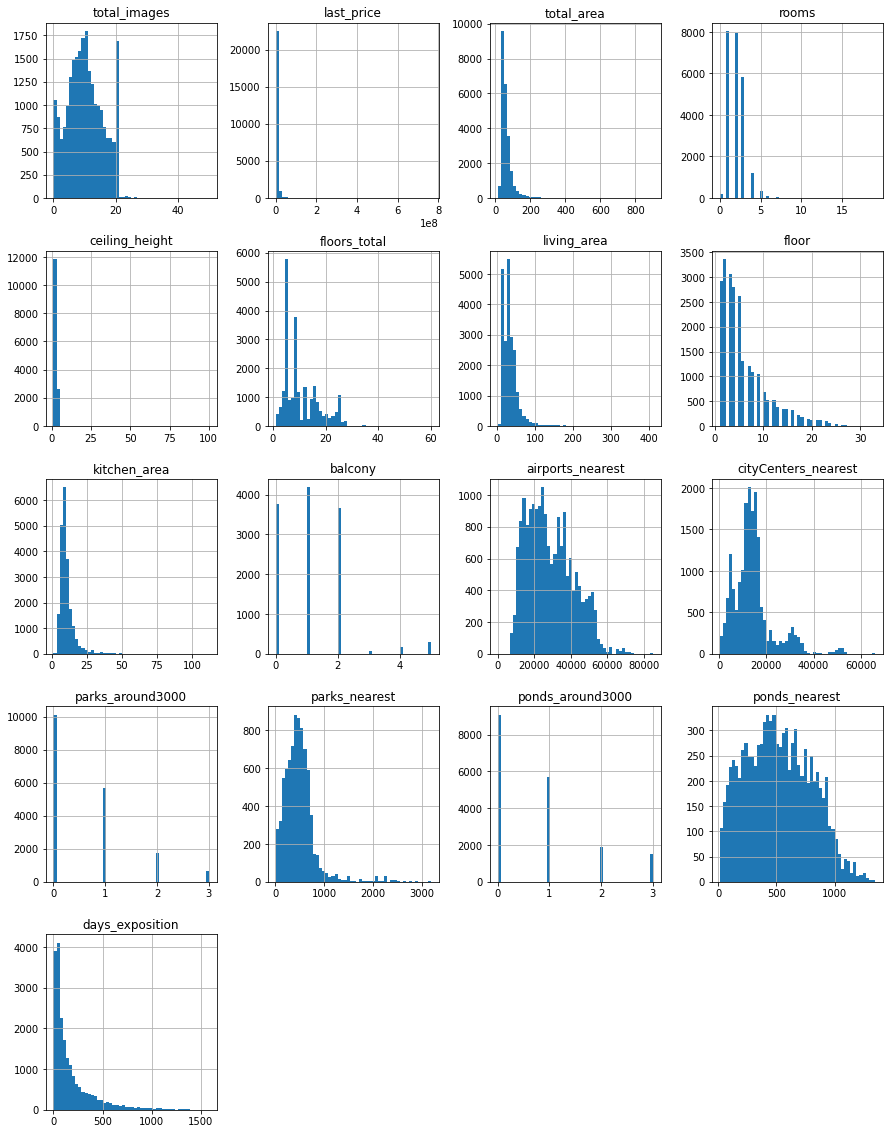

In [ ]:
# Построим гистограммы.
data.hist(figsize=(15, 20), bins=50)
plt.show()

In [ ]:
data.isna().sum().sum()

101441

**Вывод**

Количество записей в датасете 23_699, столбцов 22: bool(2), float64(14), int64(3), object(3).  
Проблемные месте датасета:  
1. last_price, ceiling_height, living_area — имеют нереальные значения (например, высота потолка ceiling_height = 1, ; living_area = 2, rooms = 0).  
2. Тип столбцов: например, количество балконов balcony сделать int,  так как это всегда целое число.  
3. Пропуски в столбцах ceiling_height, floors_total, living_area, is_apartment, kitchen_area,
balcony, locality_name, airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest, days_exposition.  
Также хочу отметить, что на гистрограммах не присутствует нормальное (или близкое к номральному) распределение.

# <a id="section2"></a>1 Выполните предобработку данных

**Заполнение пропущенных значений**

**locality_name**

In [ ]:
# Какие уникальные значения представлены в столбце и какое их количество
# locality_name
print(data['locality_name'].unique())
print(len(data['locality_name'].unique()))

['Санкт-Петербург' 'посёлок Шушары' 'городской посёлок Янино-1'
 'посёлок Парголово' 'посёлок Мурино' 'Ломоносов' 'Сертолово' 'Петергоф'
 'Пушкин' 'деревня Кудрово' 'Коммунар' 'Колпино'
 'поселок городского типа Красный Бор' 'Гатчина' 'поселок Мурино'
 'деревня Фёдоровское' 'Выборг' 'Кронштадт' 'Кировск'
 'деревня Новое Девяткино' 'посёлок Металлострой'
 'посёлок городского типа Лебяжье' 'посёлок городского типа Сиверский'
 'поселок Молодцово' 'поселок городского типа Кузьмоловский'
 'садовое товарищество Новая Ропша' 'Павловск' 'деревня Пикколово'
 'Всеволожск' 'Волхов' 'Кингисепп' 'Приозерск' 'Сестрорецк'
 'деревня Куттузи' 'посёлок Аннино' 'поселок городского типа Ефимовский'
 'посёлок Плодовое' 'деревня Заклинье' 'поселок Торковичи'
 'поселок Первомайское' 'Красное Село' 'посёлок Понтонный' 'Сясьстрой'
 'деревня Старая' 'деревня Лесколово' 'посёлок Новый Свет' 'Сланцы'
 'село Путилово' 'Ивангород' 'Мурино' 'Шлиссельбург' 'Никольское'
 'Зеленогорск' 'Сосновый Бор' 'поселок Новый Све

Есть неявные дубликаты: поселок - посёлок, Мурино - поселок Мурино.

In [ ]:
# функция для обработки неявных дубликатов
def normalize_text(text):
    if pd.isna(text):
        return np.nan
    # Приводим к нижнему регистру
    text = text.lower()
    # Заменяем варианты написания
    text = text.replace('поселок', 'посёлок')
    text = text.replace('городской посёлок', 'посёлок городского типа')
    text = text.replace('садовое товарищество', 'садоводческое некоммерческое товарищество')
    text = text.replace('посёлок станции', 'посёлок при железнодорожной станции')
    # Удаляем лишние пробелы
    text = ' '.join(text.split())
    return text.title()

# Применяем нормализацию
data['locality_name'] = data['locality_name'].apply(normalize_text)

In [ ]:
print(data['locality_name'].unique())
print(len(data['locality_name'].unique()))

['Санкт-Петербург' 'Посёлок Шушары' 'Посёлок Городского Типа Янино-1'
 'Посёлок Парголово' 'Посёлок Мурино' 'Ломоносов' 'Сертолово' 'Петергоф'
 'Пушкин' 'Деревня Кудрово' 'Коммунар' 'Колпино'
 'Посёлок Городского Типа Красный Бор' 'Гатчина' 'Деревня Фёдоровское'
 'Выборг' 'Кронштадт' 'Кировск' 'Деревня Новое Девяткино'
 'Посёлок Металлострой' 'Посёлок Городского Типа Лебяжье'
 'Посёлок Городского Типа Сиверский' 'Посёлок Молодцово'
 'Посёлок Городского Типа Кузьмоловский'
 'Садоводческое Некоммерческое Товарищество Новая Ропша' 'Павловск'
 'Деревня Пикколово' 'Всеволожск' 'Волхов' 'Кингисепп' 'Приозерск'
 'Сестрорецк' 'Деревня Куттузи' 'Посёлок Аннино'
 'Посёлок Городского Типа Ефимовский' 'Посёлок Плодовое'
 'Деревня Заклинье' 'Посёлок Торковичи' 'Посёлок Первомайское'
 'Красное Село' 'Посёлок Понтонный' 'Сясьстрой' 'Деревня Старая'
 'Деревня Лесколово' 'Посёлок Новый Свет' 'Сланцы' 'Село Путилово'
 'Ивангород' 'Мурино' 'Шлиссельбург' 'Никольское' 'Зеленогорск'
 'Сосновый Бор' 'Деревн

Теперь остались дубликаты вида "Мурино - Посёлок Мурино"

In [ ]:
# Обработаем эти дубликаты
normalization_dict = {
    'Мурино': 'Посёлок Мурино',
    'Кудрово': 'Деревня Кудрово',
    'Посёлок Городского Типа Фёдоровское': 'Деревня Фёдоровское',
    'Никольское': 'Село Никольское',
    'Посёлок Советский': 'Посёлок Городского Типа Советский',
    'Село Павлово': 'городской посёлок Павлово'

}
data['locality_name'] = data['locality_name'].replace(normalization_dict)
len(data['locality_name'].unique())

318

Было 365 уникальных значений, теперь 318.

**days_exposition**

Заполнено 20_518 значений из 23_699. Вместо пропущенных значений поставлю значение-заглушку о

In [ ]:
# Убедимся, что нуля в существующих знаечниях нет.
sorted(list(data['days_exposition'].unique()))

[nan,
 1.0,
 2.0,
 3.0000000000000004,
 4.0,
 5.0,
 6.000000000000001,
 7.0,
 8.0,
 9.0,
 10.0,
 11.000000000000002,
 12.000000000000002,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.000000000000004,
 23.000000000000004,
 24.000000000000004,
 25.0,
 26.0,
 27.0,
 28.0,
 29.0,
 30.0,
 31.0,
 32.0,
 33.0,
 34.0,
 35.0,
 36.0,
 37.0,
 38.0,
 39.0,
 40.0,
 41.0,
 42.0,
 43.0,
 44.00000000000001,
 45.00000000000001,
 46.00000000000001,
 47.00000000000001,
 48.00000000000001,
 49.0,
 50.0,
 51.0,
 52.0,
 53.0,
 54.0,
 55.0,
 56.0,
 57.0,
 58.0,
 59.0,
 60.0,
 61.0,
 62.0,
 63.0,
 64.0,
 65.0,
 66.0,
 67.0,
 68.0,
 69.0,
 70.0,
 71.0,
 72.0,
 73.0,
 74.0,
 75.0,
 76.0,
 77.0,
 78.0,
 79.0,
 80.0,
 81.0,
 82.0,
 83.0,
 84.0,
 85.0,
 86.0,
 87.00000000000001,
 88.00000000000001,
 89.00000000000001,
 90.00000000000001,
 91.0,
 92.0,
 93.0,
 94.0,
 95.0,
 96.0,
 97.0,
 98.0,
 99.0,
 100.0,
 101.0,
 102.0,
 103.0,
 104.0,
 105.0,
 106.0,
 107.0,
 108.0,
 109.0,
 110.0,
 111.0

In [ ]:
data['days_exposition'].fillna(0, inplace=True)

In [ ]:
print('🚨🚨🚨 ПРОВЕРКА. Смотри, сколько удалено % данных: ', (1 - (len(data) / 23699))* 100)

🚨🚨🚨 ПРОВЕРКА. Смори, сколько удалено % данных:  0.0


**ceiling_height**

In [ ]:
# Посмотрим какие там значения перед заполнением пропущеных значений
np.sort(data['ceiling_height'].unique())

array([  1.  ,   1.2 ,   1.75,   2.  ,   2.2 ,   2.25,   2.3 ,   2.34,
         2.4 ,   2.45,   2.46,   2.47,   2.48,   2.49,   2.5 ,   2.51,
         2.52,   2.53,   2.54,   2.55,   2.56,   2.57,   2.58,   2.59,
         2.6 ,   2.61,   2.62,   2.63,   2.64,   2.65,   2.66,   2.67,
         2.68,   2.69,   2.7 ,   2.71,   2.72,   2.73,   2.74,   2.75,
         2.76,   2.77,   2.78,   2.79,   2.8 ,   2.81,   2.82,   2.83,
         2.84,   2.85,   2.86,   2.87,   2.88,   2.89,   2.9 ,   2.91,
         2.92,   2.93,   2.94,   2.95,   2.96,   2.97,   2.98,   2.99,
         3.  ,   3.01,   3.02,   3.03,   3.04,   3.05,   3.06,   3.07,
         3.08,   3.09,   3.1 ,   3.11,   3.12,   3.13,   3.14,   3.15,
         3.16,   3.17,   3.18,   3.2 ,   3.21,   3.22,   3.23,   3.24,
         3.25,   3.26,   3.27,   3.28,   3.29,   3.3 ,   3.31,   3.32,
         3.33,   3.34,   3.35,   3.36,   3.37,   3.38,   3.39,   3.4 ,
         3.42,   3.43,   3.44,   3.45,   3.46,   3.47,   3.48,   3.49,
      

Присутствуют нереалистичные данные: потолки меньше 2 метров и больше 8,5 м. Значения 25, 27 можно поделить на 10, возможна ошибка при заполнении. Даже если после деления получится число более 8,5, то заменем его на nan.

In [ ]:
data['ceiling_height'] = data['ceiling_height'].apply(lambda x: x/10 if x >= 20 else x)
data['ceiling_height'] = np.where(
    (data['ceiling_height'] < 2) | (data['ceiling_height'] > 8.5),
    np.nan,  # Если условие истинно - ставим NaN
    data['ceiling_height']  # Если условие ложно - оставляем значение
)

In [ ]:
# Заполним пропуски медианой по населенному пункту
ceiling_median_height = data.pivot_table(index='locality_name', values='ceiling_height', aggfunc='median')
data['ceiling_height'] = data['ceiling_height'].fillna(data['locality_name'].map(ceiling_median_height['ceiling_height']))
# Посомтрим, сколько пустых значений
data['ceiling_height'].isna().sum()

134

**floors_total**

In [ ]:
# посмотрим какие значения
sorted(list(data['floors_total'].unique()))

[1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 23.0,
 24.0,
 25.0,
 26.0,
 27.0,
 nan,
 28.0,
 29.0,
 33.0,
 34.0,
 35.0,
 36.0,
 37.0,
 52.0,
 60.0]

Самое высокое жилое здание в Санкт-Петербурге — это жилой комплекс «Князь Александр Невский». Его высота составляет 126 метров, а всего в доме 37 этажей (включая 35 жилых). Посмотрим, сколько записей, у которых это значение более 35.

In [ ]:
len(data[data['floors_total'] > 35])

6

**is_apartment**

In [ ]:
# посмотрим, какие значения.
data['is_apartment'].unique()

array([nan, False, True], dtype=object)

Предположим, что параметр просто не был выбран. Заменим пропущенные значения на False.

In [ ]:
data['is_apartment'].fillna(False, inplace=True)
data['is_apartment'].unique()

array([False,  True])

**balcony**

In [ ]:
# посмотрим, какие значения
data['balcony'].unique()

array([nan,  2.,  0.,  1.,  5.,  4.,  3.])

In [ ]:
# Предположим, что пропущенные значения означают 0
data['balcony'].fillna(0, inplace=True)
data['balcony'].unique()

array([0., 2., 1., 5., 4., 3.])

**parks_around3000, ponds_around3000**

In [ ]:
# Посмотрим, какие значения и предположим, что пропущенные значения означают 0
print("Уникальные значения parks_around3000", data['parks_around3000'].unique())
print("Уникальные значения ponds_around3000", data['ponds_around3000'].unique())

Уникальные значения parks_around3000 [ 1.  0.  2. nan  3.]
Уникальные значения ponds_around3000 [ 2.  0.  3.  1. nan]


In [ ]:
print("Пустые значения parks_around3000:", data['parks_around3000'].isna().sum())
print("Пустые значения parks_nearest:", data['parks_nearest'].isna().sum())
print("Пустые значения ponds_around3000:", data['ponds_around3000'].isna().sum())
print("Пустые значения ponds_nearest:", data['ponds_nearest'].isna().sum())

Пустые значения parks_around3000: 5518
Пустые значения parks_nearest: 15620
Пустые значения ponds_around3000: 5518
Пустые значения ponds_nearest: 14589


**living_area, kitchen_area**

In [ ]:
#Сколько строк с пустым living_area
data['living_area'].isna().sum()

1903

In [ ]:
#Сколько строк с пустым kitchen_area
data['kitchen_area'].isna().sum()

2278

Пропуски в этих столбцах заполним медианным значением в зависимости от количества комнат

In [ ]:
kitchen_area_median = data.pivot_table(index='rooms', values='kitchen_area', aggfunc='median')
data['kitchen_area'] = data['kitchen_area'].fillna(data['rooms'].map(kitchen_area_median['kitchen_area']))

In [ ]:
living_area_median_height = data.pivot_table(index='rooms', values='living_area', aggfunc='median')
data['living_area'] = data['living_area'].fillna(data['rooms'].map(living_area_median_height['living_area']))

In [ ]:
print(data['living_area'].isna().sum())
print(data['kitchen_area'].isna().sum())

0
197


In [ ]:
# В скольких строках living_area + kitchen_area > total_area
check_area = len(data[data['living_area'] + data['kitchen_area'] > data['total_area']])
check_area

302

Пока их удалять не будем

**Возможные причины пропусков в данных**  
Человеческий фактор: ошибки ввода данных — операторы или пользователи могли пропустить поля при заполнении форм, нежелание делиться информацией — клиенты могли отказаться предоставлять определенные данные, технические сбои при вводе данных в систему.

Системные причины:проблемы интеграции между различными системами и базами данных, ошибки миграции данных при переносе из старых систем, несовместимость форматов данных между различными источниками.

Бизнес-процессы: изменения в формах — при обновлении форм сбора данных некоторые поля могли стать необязательными, разные требования к данным в зависимости от типа продукта или услуги, историческое наследие — старые записи могли не содержать информацию, которая стала обязательной позже.

Технические сбои:проблемы с сетью при передаче данных, сбои в работе программного обеспечения, ограничения хранения данных в определенных полях.

Методологические причины: некорректная настройка валидации данных, отсутствие обязательных полей в формах, неправильная логика сбора данных.

Внешние факторы:катаклизмы и форс-мажорные ситуации, проблемы с оборудованием при сборе данных, ошибки при экспорте/импорте данных.

Организационные причины: отсутствие четких инструкций по заполнению форм, недостаточная обученность персонала, отсутствие контроля качества данных

**Преобразование типов**

In [ ]:
# Преобразование типов
data['balcony'] = data['balcony'].astype('int64')
data['is_apartment'] = data['is_apartment'].astype('bool')
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'])
data['parks_around3000'] = data['parks_around3000'].astype('Int64')
data['ponds_around3000'] = data['ponds_around3000'].astype('Int64')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        23565 non-null  float64       
 6   floors_total          23613 non-null  float64       
 7   living_area           23699 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          23502 non-null  float64       
 13  balcony         

Количество балконов balcony, количество парков и водоемов parks_around3000, ponds_around3000  - всегда целое число, is_apartment принимает значения True, False, поэтому оптимален тип bool. Столбец с датой преобразовала в datetime для удобства анализа, применения функция для работы с датой.

In [ ]:
print('🚨🚨🚨 ПРОВЕРКА. Смотри, сколько удалено % данных: ', (1 - (len(data) / 23699))* 100)

🚨🚨🚨 ПРОВЕРКА. Смори, сколько удалено % данных:  0.0


In [ ]:
data.isna().sum().sum()

52772

**Вывод**  
В результате предобработки сформирован датасет из 23_699 записей, включающий 1 столбец формата datetime, 6 — int, 3 — bool, 11 — float и 1 — object; при этом количество пропусков удалось сократить почти вдвое — с 101_441 до 52_772. Пропуски были заполнены для столбцов ceiling_height, living_area, kitchen_area, balcony и is_apartment, тогда как в столбцах с суффиксом «nearest» оставлены без заполнения, поскольку эти столбцы отражают расстояние до определённых объектов: отсутствие значения может означать как утрату данных, так и фактическое отсутствие объекта в зоне доступности. Аналогично не заполнены пропуски в столбцах с суффиксом «around3000», так как большое количество пропущенных значений в столбцах «nearest» существенно затрудняет корректное восстановление недостающих данных.

# <a id="section3"></a>2 Добавьте в таблицу новые столбцы

**цена одного квадратного метра (нужно поделить стоимость объекта на его общую площадь, а затем округлить до двух знаков после запятой)**

In [ ]:
data['sq.m. price'] = round(data['last_price'] / data['total_area'], 2)

**день недели публикации объявления (0 — понедельник, 1 — вторник и так далее)**

In [ ]:
data['weekday_fd_exp'] = data['first_day_exposition'].dt.weekday

**месяц публикации объявления**

In [ ]:
data['month_fd_exp'] = data['first_day_exposition'].dt.month

**год публикации объявления**

In [ ]:
data['year_fd_exp'] = data['first_day_exposition'].dt.year

**тип этажа квартиры (значения — «‎первый», «последний», «другой»)**

In [ ]:
# вспомогательная фукнция
def determine_floor_type(row):
    # Проверяем, есть ли данные для расчета
    if pd.isna(row['floor']) or pd.isna(row['floors_total']):
        return np.nan

    # Определяем тип этажа
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'

# Применяем функцию к DataFrame
data['floor_type'] = data.apply(determine_floor_type, axis=1)

**расстояние до центра города в километрах (целое значение)**

In [ ]:
data['cityCenters_nearest, km'] = round(data['cityCenters_nearest'] / 1000, 2)

In [ ]:
# Посмотрим, что получилось
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   total_images             23699 non-null  int64         
 1   last_price               23699 non-null  float64       
 2   total_area               23699 non-null  float64       
 3   first_day_exposition     23699 non-null  datetime64[ns]
 4   rooms                    23699 non-null  int64         
 5   ceiling_height           23565 non-null  float64       
 6   floors_total             23613 non-null  float64       
 7   living_area              23699 non-null  float64       
 8   floor                    23699 non-null  int64         
 9   is_apartment             23699 non-null  bool          
 10  studio                   23699 non-null  bool          
 11  open_plan                23699 non-null  bool          
 12  kitchen_area             23502 n

**Вывод**    
В датасете появилось 6 новых столбцов. "cityCenters_nearest, km" содержит пропуски, так как "cityCenters_nearest", на основе которого он рассчитан, имеет пропуски.

# <a id="section4"></a>3 Проведите исследовательский анализ данных

In [ ]:
# функция для типовых действий (для изучения каждого параметра)
def explore(data, column = '', graph_name='', x_name='', y_name='', bins_=100):
    print(data[column].describe())
    print("Количество пустых значений:", data[column].isna().sum(), sep=' ')
    data[column].hist(bins=bins_)
    plt.title(label=graph_name)
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.show()
    print("Квантили 25, 50, 75:")
    print(data[column].quantile([0.25, 0.5, 0.75]))
    data[column].plot(kind='box')
    plt.title(f'Боксплот для {column}')
    plt.ylabel(x_name)
    clean_data = data[column].dropna().values
    q1 = np.percentile(clean_data, 25)
    q3 = np.percentile(clean_data, 75)
    iqr = q3 - q1
    # Определяем границы выбросов
    lower_bound = q1 - 1.5 * iqr if q1 - 1.5 * iqr > min(clean_data) else min(clean_data)
    upper_bound = q3 + 1.5 * iqr if q3 + 1.5 * iqr < max(clean_data) else max(clean_data)
    print("Границы значений:")
    print(round(lower_bound, 3), round(upper_bound, 3))
    plt.show()

# функция для опредления границ выбросов с помощью правила 3 сигмы
def bounds(data, column = ''):
    clean_data = data[column].dropna().values
    q1 = np.percentile(clean_data, 25)
    q3 = np.percentile(clean_data, 75)
    iqr = q3 - q1
    # Определяем границы выбросов
    lower_bound = q1 - 1.5 * iqr if q1 - 1.5 * iqr > min(clean_data) else min(clean_data)
    upper_bound = q3 + 1.5 * iqr if q3 + 1.5 * iqr < max(clean_data) else max(clean_data)
    return round(lower_bound, 3), round(upper_bound, 4)

**общая площадь**

count   23,699.00
mean        60.35
std         35.65
min         12.00
25%         40.00
50%         52.00
75%         69.90
max        900.00
Name: total_area, dtype: float64
Количество пустых значений: 0


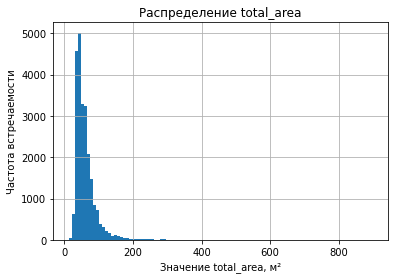

Квантили 25, 50, 75:
0.25   40.00
0.50   52.00
0.75   69.90
Name: total_area, dtype: float64
Границы значений:
12.0 114.75


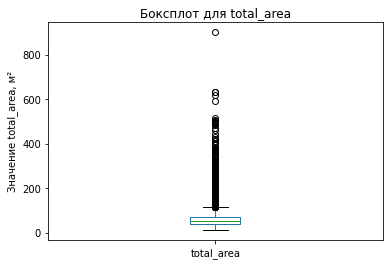

In [ ]:
# Выведем информацию
explore(
    data,
    column='total_area',
    graph_name='Распределение total_area',
    x_name='Значение total_area, м²',
    y_name='Частота встречаемости'
)

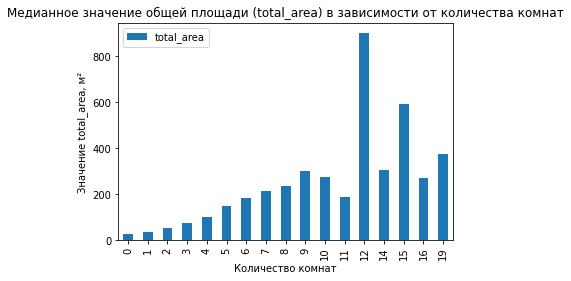

In [ ]:
# Посмотрим в разрезе количества комнат
data.pivot_table(index='rooms', values='total_area', aggfunc='median').plot(kind='bar')
plt.title("Медианное значение общей площади (total_area) в зависимости от количества комнат")
plt.xlabel("Количество комнат")
plt.ylabel("Значение total_area, м²")
plt.show()

In [ ]:
#На графике у квартир с 12 комнатами наблюдается пик, посмотрим на них
data[data['rooms'] == 12]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,sq.m. price,weekday_fd_exp,month_fd_exp,year_fd_exp,floor_type,"cityCenters_nearest, km"
19540,8,"420,000,000.00",900.00,2017-12-06,12,2.80,25.00,409.70,25,False,...,NaN,2,318.00,106.00,"466,666.67",2,12,2017,последний,7.88


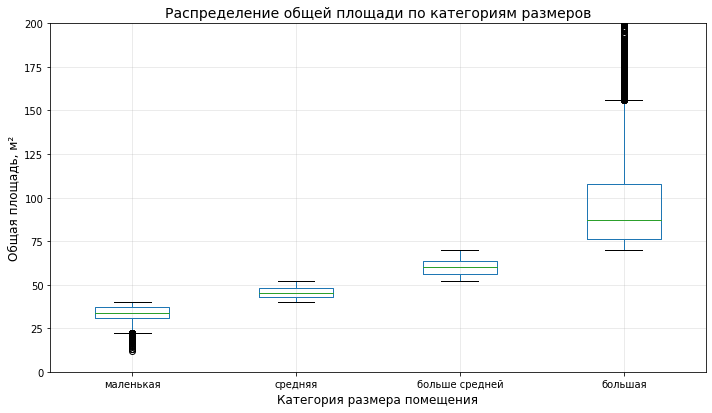

In [ ]:
# Выделим категории, работаем с копией датасета
total_area_cat_temp = data.copy()
bins = [0, 40.0, 52.0, 69.9, float('inf')]
labels = ['маленькая', 'средняя', 'больше средней', 'большая']
total_area_cat_temp['category'] = pd.cut(total_area_cat_temp['total_area'], bins=bins, labels=labels)

# Строим боксплот
total_area_cat_temp.boxplot(
    by='category',
    column=['total_area'],
    figsize=(10, 6)  # Размер графика для лучшей читаемости
)

# Подписи на русском языке
plt.title('Распределение общей площади по категориям размеров', fontsize=14)
plt.xlabel('Категория размера помещения', fontsize=12)
plt.ylabel('Общая площадь, м²', fontsize=12)

# Ограничиваем ось Y
plt.ylim([0, 200])

# Дополнительно: улучшаем оформление
plt.grid(True, alpha=0.3)
plt.suptitle('')  # Убираем автоматический заголовок от .boxplot(by=...)
plt.tight_layout()  # Оптимизируем отступы

plt.show()

Условимся, что выбросами будем считать значения, которые находятся ниже нижней границы для категория "маленькая" и выше верхней границы для категории "большая". Вычисилим их.

In [ ]:
print(bounds(total_area_cat_temp[total_area_cat_temp['category'] == 'маленькая'], column = 'total_area'))
print(bounds(total_area_cat_temp[total_area_cat_temp['category'] == 'большая'], column = 'total_area'))

(22.25, 40.0)
(70.0, 155.85)


category  маленькая  средняя  больше средней  большая
rooms                                                
0               188        4               1        4
1              5708     2075             226       38
2               145     3574            3248      973
3                 0      179            2281     3354
4                 0       81              61     1038
5                 1        0               6      319
6                 0        0               0      105
7                 0        0               0       59
8                 0        0               0       12
9                 0        0               0        8
10                0        0               0        3
11                0        0               0        2
12                0        0               0        1
14                0        0               0        2
15                0        0               0        1
16                0        0               0        1
19                0        0

<Figure size 1080x720 with 0 Axes>

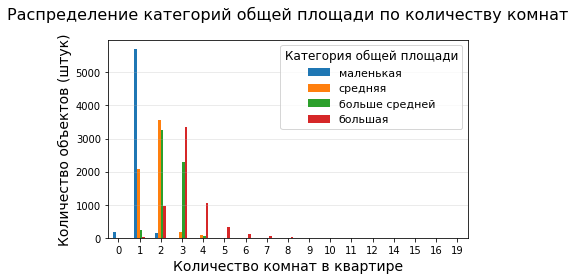

In [ ]:
# Изучим какие категории по площади преобладают в зависимости от количества комнат
graph_total_area = total_area_cat_temp.groupby(['rooms', 'category']).size().unstack()
# Выводим таблицу для контроля
print(graph_total_area)

plt.figure(figsize=(15, 10))
graph_total_area.plot(kind='bar', stacked=False)
plt.title('Распределение категорий общей площади по количеству комнат', fontsize=16, pad=20)
plt.xlabel('Количество комнат в квартире', fontsize=14)
plt.ylabel('Количество объектов (штук)', fontsize=14)
plt.legend(title='Категория общей площади', title_fontsize=12, fontsize=11)
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

**Вывод**  
По данным статистики: среднее — 60.35, медиана — 52.00. Далее при анализе будут использоваться значения от 22.25 до 155.85 (фактический минимум — 12, максимум — 900), значения вне этого отрезка считаются выбросами. Распределение имеет правосторонний перекос (среднее больше медианы).
С ростом количества комнат наблюдается рост общей площади, в точке 9 (9 комнат) фиксируется спад до точки 12 комнат. В точке 12 (12 комнат) наблюдаетя высокий пик из-за наличия в датасете квартиры с экстремально большой площадью - 900 кв. м., далее характер зависимости менется (становится скачкообразный), скорее всего, при таком большом количестве комнат большую роль играет планировка и метраж каждой комнаты. В студиях и однокомнатных квартирах преобладают квартиры малой жилой площади (188 и 5_708 квартир соответственно), в двухкомнантных квартирах с небольшим отрывом преобладают квартиры средней площади (3_574 квартир), далее преобладают квартиры бОльшей площади.  

**жилая площадь**

count   23,699.00
mean        34.32
std         21.70
min          2.00
25%         18.40
50%         30.30
75%         42.70
max        409.70
Name: living_area, dtype: float64
Количество пустых значений: 0


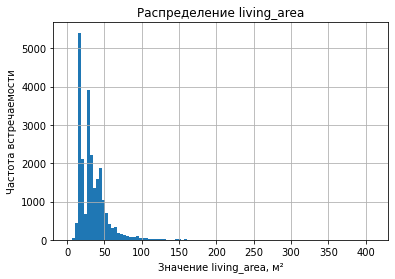

Квантили 25, 50, 75:
0.25   18.40
0.50   30.30
0.75   42.70
Name: living_area, dtype: float64
Границы значений:
2.0 79.15


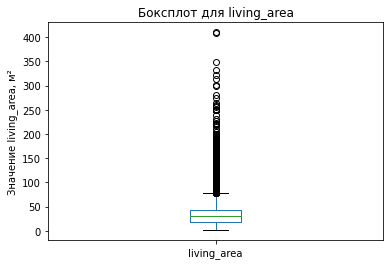

In [ ]:
# Выведем информацию
explore(
    data,
    column='living_area',
    graph_name='Распределение living_area',
    x_name='Значение living_area, м²',
    y_name='Частота встречаемости'
)

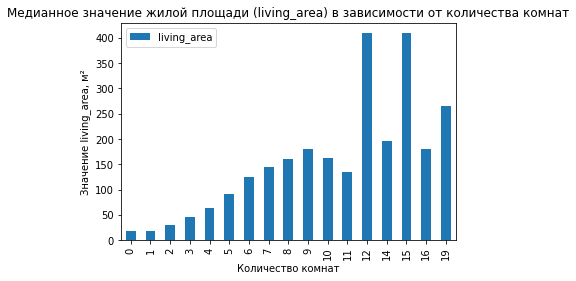

In [ ]:
# Посмотрим в разрезе количества комнат
data.pivot_table(index='rooms', values='living_area', aggfunc='median').plot(kind='bar')
plt.title("Медианное значение жилой площади (living_area) в зависимости от количества комнат")
plt.xlabel("Количество комнат")
plt.ylabel("Значение living_area, м²")
plt.show()

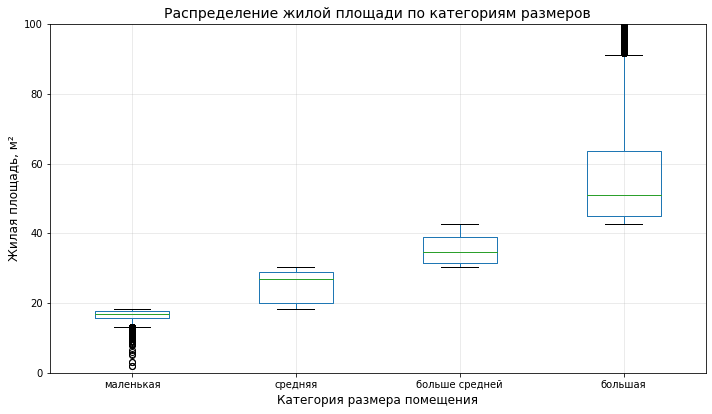

In [ ]:
# Выделим категории, работаем с копией датасета
living_area_cat_temp = data.copy()
bins = [0, 18.4, 30.3, 42.7, float('inf')]
labels = ['маленькая', 'средняя', 'больше средней', 'большая']
living_area_cat_temp['category'] = pd.cut(living_area_cat_temp['living_area'], bins=bins, labels=labels)

# Строим боксплот
living_area_cat_temp.boxplot(
    by='category',
    column=['living_area'],
    figsize=(10, 6)  # Размер графика для лучшей читаемости
)

# Подписи на русском языке
plt.title('Распределение жилой площади по категориям размеров', fontsize=14)
plt.xlabel('Категория размера помещения', fontsize=12)
plt.ylabel('Жилая площадь, м²', fontsize=12)

# Ограничиваем ось Y
plt.ylim([0, 100])

# Дополнительно: улучшаем оформление
plt.grid(True, alpha=0.3)
plt.suptitle('')  # Убираем автоматический заголовок от .boxplot(by=...)
plt.tight_layout()  # Оптимизируем отступы

plt.show()

Условимся, что выбросами будем считать значения, которые находятся ниже нижней границы для категория "маленькая" и выше верхней границы для категории "огромная". Вычисилим их.

In [ ]:
print(bounds(living_area_cat_temp[living_area_cat_temp['category'] == 'маленькая'], column = 'living_area'))
print(bounds(living_area_cat_temp[living_area_cat_temp['category'] == 'большая'], column = 'living_area'))

(13.1, 18.4)
(42.8, 91.5)


category  маленькая  средняя  больше средней  большая
rooms                                                
0               122       70               2        3
1              5765     2198              69       15
2                55     3531            3995      359
3                 5      102            1774     3933
4                 1        2              89     1088
5                 0        3               1      322
6                 0        0               0      105
7                 0        0               0       59
8                 0        0               0       12
9                 0        0               0        8
10                0        0               0        3
11                0        0               0        2
12                0        0               0        1
14                0        0               0        2
15                0        0               0        1
16                0        0               0        1
19                0        0

<Figure size 1080x720 with 0 Axes>

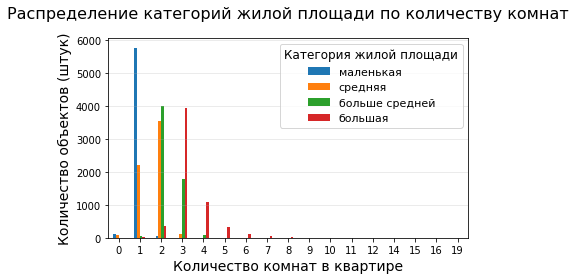

In [ ]:
# Изучим какие категории по площади преобладают в зависимости от количества комнат
graph_living_area = living_area_cat_temp.groupby(['rooms', 'category']).size().unstack()
# Выводим таблицу для контроля
print(graph_living_area)
plt.figure(figsize=(15, 10))
graph_living_area.plot(kind='bar', stacked=False)
plt.title('Распределение категорий жилой площади по количеству комнат', fontsize=16, pad=20)
plt.xlabel('Количество комнат в квартире', fontsize=14)
plt.ylabel('Количество объектов (штук)', fontsize=14)
plt.legend(title='Категория жилой площади', title_fontsize=12, fontsize=11)
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

**Вывод**  
По данным анализа жилой площади: среднее значение — 34.32 кв.м, медиана — 30.3 кв.м, распределение имеет правосторонний перекос (среднее больше медианы), определены границы значений от 13.1 до 91.5 кв.м (значения вне диапазона считаются выбросами), присутствует экстремальное значение 409.7 кв.м. В студиях и 1-комнатных квартирах преобладет маленькая жилая площадь - 122 и 5_765 квартир соответсвенно, в 2-комнатных - больше средней (3_995 квартир), далее преобладают квартиры с большой жилой площадью.

**kitchen_area**

count   23,502.00
mean        10.46
std          5.66
min          1.30
25%          7.30
50%          9.04
75%         11.50
max        112.00
Name: kitchen_area, dtype: float64
Количество пустых значений: 197


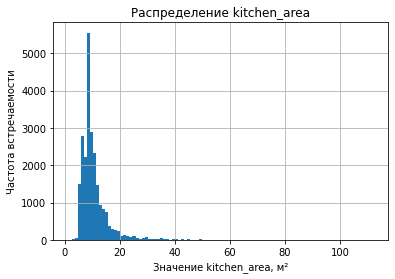

Квантили 25, 50, 75:
0.25    7.30
0.50    9.04
0.75   11.50
Name: kitchen_area, dtype: float64
Границы значений:
1.3 17.8


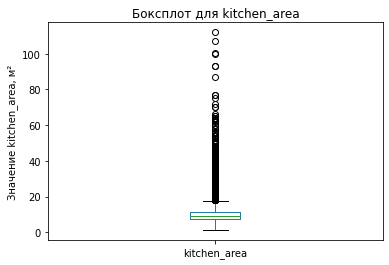

In [ ]:
# Выведем информацию
explore(
    data,
    column='kitchen_area',
    graph_name='Распределение kitchen_area',
    x_name='Значение kitchen_area, м²',
    y_name='Частота встречаемости'
)

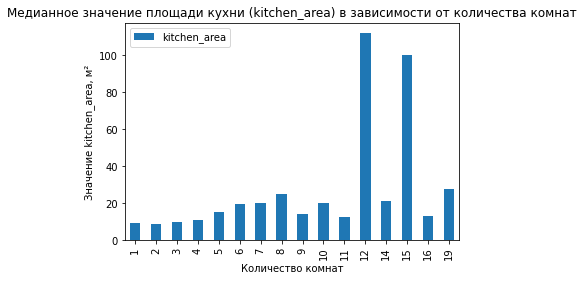

In [ ]:
# Посмотрим в разрезе количества комнат
data.pivot_table(index='rooms', values='kitchen_area', aggfunc='median').plot(kind='bar')
plt.title("Медианное значение площади кухни (kitchen_area) в зависимости от количества комнат")
plt.xlabel("Количество комнат")
plt.ylabel("Значение kitchen_area, м²")
plt.show()

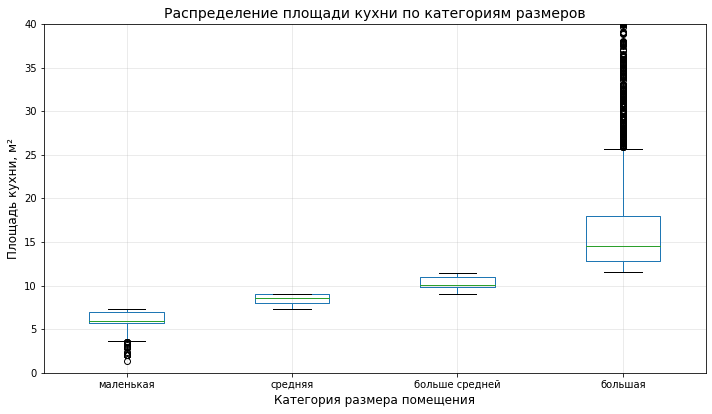

In [ ]:
# Выделим категории, работаем с копией датасета
kitchen_area_cat_temp = data.copy()
bins = [0, 7.3, 9.04, 11.5, float('inf')]
labels = ['маленькая', 'средняя', 'больше средней', 'большая']
kitchen_area_cat_temp['category'] = pd.cut(kitchen_area_cat_temp['kitchen_area'], bins=bins, labels=labels)
kitchen_area_cat_temp.boxplot(
    by='category',
    column=['kitchen_area'],
    figsize=(10, 6)  # Размер графика для лучшей читаемости
)
plt.title('Распределение площади кухни по категориям размеров', fontsize=14)
plt.xlabel('Категория размера помещения', fontsize=12)
plt.ylabel('Площадь кухни, м²', fontsize=12)
plt.ylim([0, 40])
plt.grid(True, alpha=0.3)
plt.suptitle('')
plt.tight_layout()
plt.show()

Условимся, что выбросами будем считать значения, которые находятся ниже нижней границы для категория "маленькая" и выше верхней границы для категории "огромная". Вычисилим их.


In [ ]:
print(bounds(kitchen_area_cat_temp[kitchen_area_cat_temp['category'] == 'маленькая'], column = 'kitchen_area'))
print(bounds(kitchen_area_cat_temp[kitchen_area_cat_temp['category'] == 'большая'], column = 'kitchen_area'))

(3.7, 7.3)
(11.51, 25.8)


category  маленькая  средняя  больше средней  большая
rooms                                                
0                 0        0               0        0
1              1832     2609            2233     1373
2              2388     2327            1479     1746
3              1457     1110            1450     1797
4               232      135             299      514
5                 8       20              48      250
6                 1        3              12       89
7                 1        1               2       55
8                 2        0               0       10
9                 0        0               0        8
10                0        0               0        3
11                0        0               0        2
12                0        0               0        1
14                0        0               0        2
15                0        0               0        1
16                0        0               0        1
19                0        0

<Figure size 1080x720 with 0 Axes>

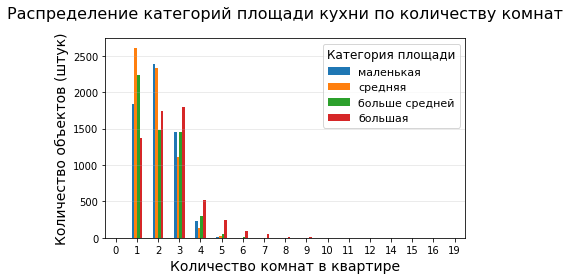

In [ ]:
# Изучим какие категории по площади преобладают в зависимости от количества комнат
graph_kitchen_area = kitchen_area_cat_temp.groupby(['rooms', 'category']).size().unstack()
print(graph_kitchen_area)
plt.figure(figsize=(15, 10))
graph_kitchen_area.plot(kind='bar', stacked=False)
plt.title('Распределение категорий площади кухни по количеству комнат', fontsize=16, pad=20)
plt.xlabel('Количество комнат в квартире', fontsize=14)
plt.ylabel('Количество объектов (штук)', fontsize=14)
plt.legend(title='Категория площади', title_fontsize=12, fontsize=11)
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

**Вывод**  
По данным анализа площади кухонь: среднее значение — 10.46 кв.м, медиана — 9.04 кв.м, распределение имеет умеренный перекос вправо (среднее больше медианы), определены границы значений от 3.7 до 25.8 кв.м (значения вне диапазона считаются выбросами), присутствует экстремальное значение 112.0 кв.м. Интересно, что в однокомнатных квартирах преобладают кухни среднего размера (2_609 квартир), в двухкомнатных - маленького размера и среднего размера (2_388 и 2_377 квартир соответственно), а начиная с трехкомнатных - большого размера.

#### **Общий вывод по анализу трех площадей**   
Общий вывод по трем параметрам площади квартир    
Изучив данные по представленной недвижимости, в разрезе трех параметров: общей площади, жилой площади и площади кухни, можно выделить следующие основные характеристики.

В однокомнатных квартирах преобладают:  
-в общей площади — категория квартир маленького размера до 40.00 кв.м;  
-в жилой площади — категория маленьких жилых площадей до 18.40  кв.м;  
-в площади кухонь — категория средних кухонь от 7.30 до 9.04  кв.м.  

В двухкомнатных квартирах преобладают:  
-в общей площади — категория квартир среднего размера от 40.00 до 52.00, кв.м;  
-в жилой площади — категория средних жилых площадей от 18.40 до 30.30 кв.м;  
-в площади кухонь — категория маленьких кухонь до 7.30 и средних кухонь до 7.30 до 9.04 кв.м.  

В трехкомнатных квартирах и далее преобладают:  
-в общей площади — категория квартир большого размера от 69.90 кв.м и выше;  
-в жилой площади — категория больших жилых площадей от 42.70 кв.м;  
-в площади кухонь — категория больших кухонь от 11.50 кв.м и выше.  


Отдельно стоит отметить квартиры с 0 комнат, квартиры-студии: это квартиры с маленькой жилой и общей площадью.

Таким образом, сборный образ однокомнатной квартиры: маленькая квартира со средней кухней. Двухкомнатной — средняя квартира с маленькой или средней кухней кухней. Трехкомнатные квартиры — это большие квартиры с относительно большой жилой площадью и большой кухней.

**цена объекта**

count        23,699.00
mean      6,541,548.77
std      10,887,013.27
min          12,190.00
25%       3,400,000.00
50%       4,650,000.00
75%       6,800,000.00
max     763,000,000.00
Name: last_price, dtype: float64
Количество пустых значений: 0


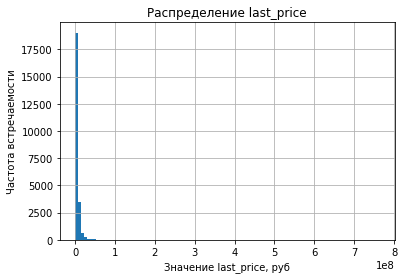

Квантили 25, 50, 75:
0.25   3,400,000.00
0.50   4,650,000.00
0.75   6,800,000.00
Name: last_price, dtype: float64
Границы значений:
12190.0 11900000.0


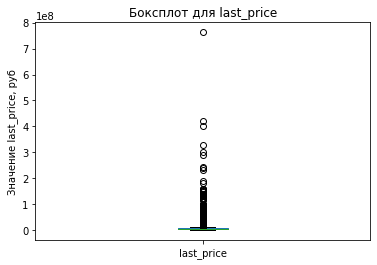

In [ ]:
# Выведем информацию
explore(
    data,
    column='last_price',
    graph_name='Распределение last_price',
    x_name='Значение last_price, руб',
    y_name='Частота встречаемости'
)

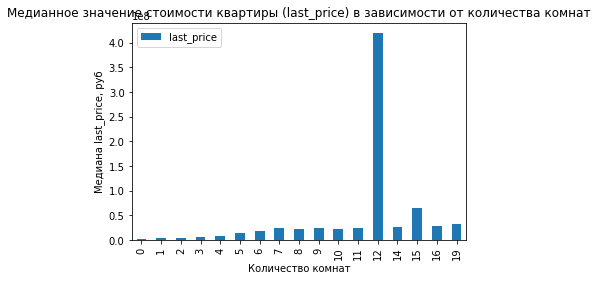

In [ ]:
# Посмотрим в разрезе количества комнат (медианная цена)
data.pivot_table(index='rooms', values='last_price', aggfunc='median').plot(kind='bar')
plt.title("Медианное значение стоимости квартиры (last_price) в зависимости от количества комнат")
plt.xlabel("Количество комнат")
plt.ylabel("Медиана last_price, руб")
plt.show()

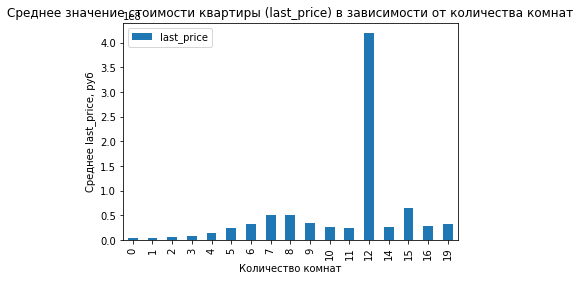

In [ ]:
# Посмотрим в разрезе количества комнат (_средняя_ цена)
data.pivot_table(index='rooms', values='last_price', aggfunc='mean').plot(kind='bar')
plt.title("Среднее значение стоимости квартиры (last_price) в зависимости от количества комнат")
plt.xlabel("Количество комнат")
plt.ylabel("Среднее last_price, руб")
plt.show()

In [ ]:
data['last_price'].quantile([0.2, 0.4, 0.6, 0.8])

0.20   3,190,000.00
0.40   4,104,250.40
0.60   5,295,000.00
0.80   7,585,000.00
Name: last_price, dtype: float64

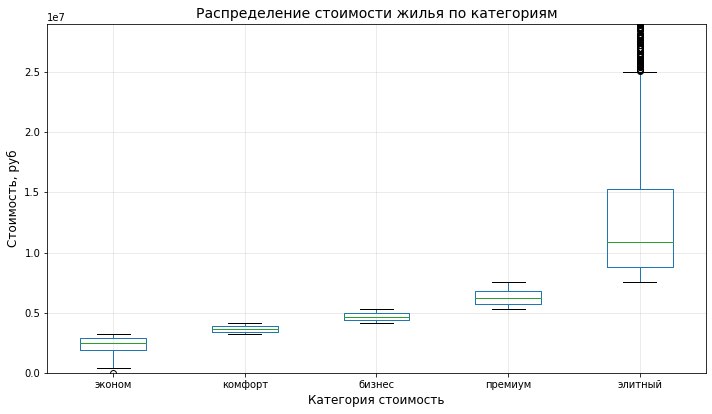

In [ ]:
# Изучим какие категории по стоимости преобладают в зависимости от количества комнат
last_price_cat_temp = data.copy()
bins = [0, 3190000.0, 4104250.0, 5295000.0, 7585000.0, float('inf')]
labels = ['эконом', 'комфорт', 'бизнес', 'премиум', 'элитный']
last_price_cat_temp['category'] = pd.cut(last_price_cat_temp['last_price'], bins=bins, labels=labels)
last_price_cat_temp.boxplot(
    by='category',
    column=['last_price'],
    figsize=(10, 6)
)
plt.title('Распределение стоимости жилья по категориям', fontsize=14)
plt.xlabel('Категория стоимость', fontsize=12)
plt.ylabel('Стоимость, руб', fontsize=12)

# Ограничиваем ось Y
plt.ylim([0, 29000000])

# Дополнительно: улучшаем оформление
plt.grid(True, alpha=0.3)
plt.suptitle('')  # Убираем автоматический заголовок от .boxplot(by=...)
plt.tight_layout()  # Оптимизируем отступы

plt.show()

Условимся, что выбросами будем считать значения, которые находятся ниже нижней границы для категория "эконом" и выше верхней границы для категории "элитный". Вычисилим их.

In [ ]:
print(bounds(last_price_cat_temp[last_price_cat_temp['category'] == 'эконом'], column = 'last_price'))
print(bounds(last_price_cat_temp[last_price_cat_temp['category'] == 'элитный'], column = 'last_price'))

(350000.0, 3190000.0)
(7590000.0, 25050000.0)


category  эконом  комфорт  бизнес  премиум  элитный
rooms                                              
0            127       55       7        4        4
1           2748     2673    1646      792      188
2           1347     1460    1891     1915     1327
3            478      459    1102     1763     2012
4             49       76      82      247      726
5              7        1      12       16      290
6              0        0       1        2      102
7              0        0       0        0       59
8              0        0       0        0       12
9              0        0       0        0        8
10             0        0       0        0        3
11             0        0       0        0        2
12             0        0       0        0        1
14             0        0       0        0        2
15             0        0       0        0        1
16             0        0       0        0        1
19             0        0       0        0        1


<Figure size 1080x720 with 0 Axes>

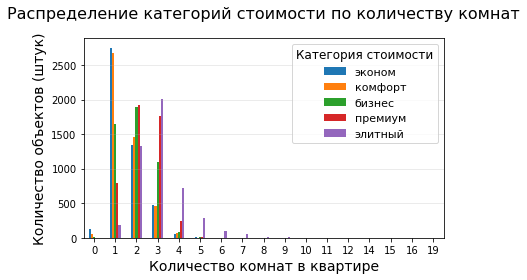

In [ ]:
graph_last_price = last_price_cat_temp.groupby(['rooms', 'category']).size().unstack()
# Выводим таблицу для контроля
print(graph_last_price)
plt.figure(figsize=(15, 10))
graph_last_price.plot(kind='bar', stacked=False)
plt.title('Распределение категорий стоимости по количеству комнат', fontsize=16, pad=20)
plt.xlabel('Количество комнат в квартире', fontsize=14)
plt.ylabel('Количество объектов (штук)', fontsize=14)
plt.legend(title='Категория стоимости', title_fontsize=12, fontsize=11)
plt.grid(axis='y', alpha=0.3)  # сетка только по оси Y для лучшей читаемости
plt.xticks(rotation=0)  # горизонтальное расположение подписей по оси X
plt.tight_layout()  # оптимизируем отступы
plt.show()

**Вывод**    
В целом с ростом комнат при визуальном изучении графика наблюдается рост медианной стоимости (боксплоты). Для студии характерна стомость из категории "эконом" (127 квартир), для 1-комнатных квартир - из категории "эконом" и "комофрт" (2_748  и 2_673 квартир соответсвенно), для 2-комнатных - "бизнес" и "премиум" (1_871 и 1_915 квартир соответственно), для 3-комнатных и более - "элитный". Граница для значений, которые не считаются выбросами, - от 350_000.0 до 25_050_000.0.

**количество комнат**

count   23,699.00
mean         2.07
std          1.08
min          0.00
25%          1.00
50%          2.00
75%          3.00
max         19.00
Name: rooms, dtype: float64
Количество пустых значений: 0


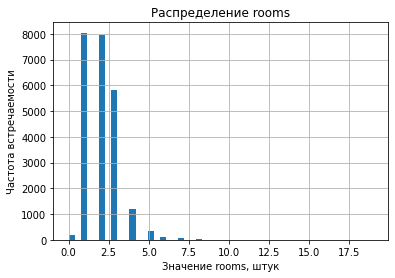

Квантили 25, 50, 75:
0.25   1.00
0.50   2.00
0.75   3.00
Name: rooms, dtype: float64
Границы значений:
0 6.0


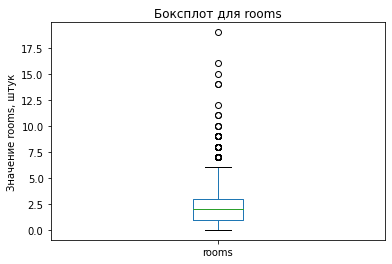

In [ ]:
# Выведем информацию
explore(
    data,
    column='rooms',
    graph_name='Распределение rooms',
    x_name='Значение rooms, штук',
    y_name='Частота встречаемости',
    bins_=50
)


In [ ]:
data['rooms'].value_counts()

1     8047
2     7940
3     5814
4     1180
5      326
0      197
6      105
7       59
8       12
9        8
10       3
11       2
14       2
19       1
16       1
12       1
15       1
Name: rooms, dtype: int64

**Вывод**    
Большая чаасть квартир имеет 0-3 комнат (не меньше 75 % квартир).   
P.S. В предыдущих ячейках была изучена связь между количество комнат, площадью, стоимостью.
Будем считаться аномальными значения количество комнат более 11.

**ceiling_height**

count   23,565.00
mean         2.70
std          0.24
min          2.00
25%          2.55
50%          2.70
75%          2.70
max          8.30
Name: ceiling_height, dtype: float64
Количество пустых значений: 134


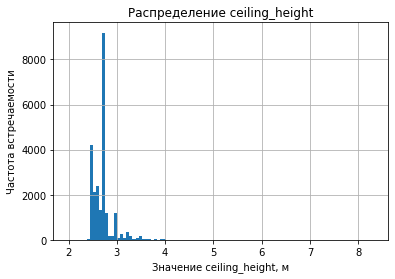

Квантили 25, 50, 75:
0.25   2.55
0.50   2.70
0.75   2.70
Name: ceiling_height, dtype: float64
Границы значений:
2.325 2.925


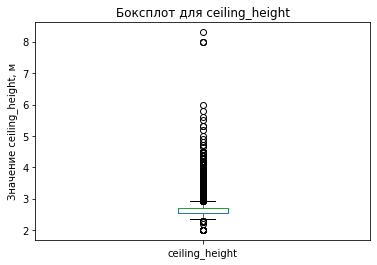

In [ ]:
# Выведем информацию
explore(
    data,
    column='ceiling_height',
    graph_name='Распределение ceiling_height',
    x_name='Значение ceiling_height, м',
    y_name='Частота встречаемости'
)

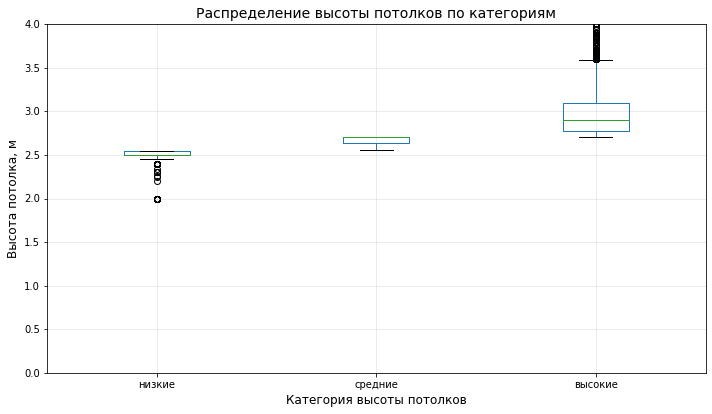

In [ ]:
# Выделим категории, работаем с копией датасета
ceiling_height_cat_temp = data.copy()
bins = [0, 2.55, 2.7, float('inf')]
labels = ['низкие', 'средние', 'высокие']
ceiling_height_cat_temp['category'] = pd.cut(ceiling_height_cat_temp['ceiling_height'], bins=bins, labels=labels)

# Строим боксплот
ceiling_height_cat_temp.boxplot(
    by='category',
    column=['ceiling_height'],
    figsize=(10, 6)  # Размер графика для лучшей читаемости
)

# Подписи на русском языке
plt.title('Распределение высоты потолков по категориям', fontsize=14)
plt.xlabel('Категория высоты потолков', fontsize=12)
plt.ylabel('Высота потолка, м', fontsize=12)

# Ограничиваем ось Y
plt.ylim([0, 4])

# Дополнительно: улучшаем оформление
plt.grid(True, alpha=0.3)
plt.suptitle('')  # Убираем автоматический заголовок от .boxplot(by=...)
plt.tight_layout()  # Оптимизируем отступы

plt.show()

category  низкие  средние  высокие
rooms                             
0              3      134       58
1           1965     4539     1507
2           2378     3801     1700
3           1566     2676     1539
4            225      487      466
5             21      114      191
6              3       35       67
7              0       18       41
8              1        5        6
9              1        1        6
10             0        0        3
11             0        0        2
12             0        0        1
14             0        1        1
15             0        0        1
16             0        0        1
19             0        1        0


<Figure size 1080x720 with 0 Axes>

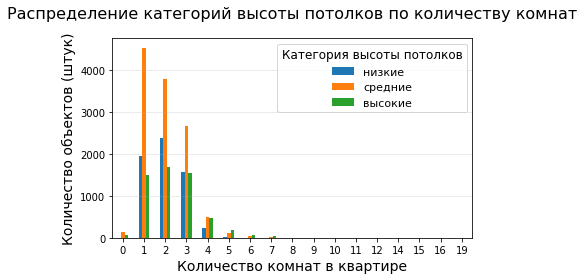

In [ ]:
graph_ceiling_height = ceiling_height_cat_temp.groupby(['rooms', 'category']).size().unstack()
# Выводим таблицу для контроля
print(graph_ceiling_height)
plt.figure(figsize=(15, 10))
graph_ceiling_height.plot(kind='bar', stacked=False)
plt.title('Распределение категорий высоты потолков по количеству комнат', fontsize=16, pad=20)
plt.xlabel('Количество комнат в квартире', fontsize=14)
plt.ylabel('Количество объектов (штук)', fontsize=14)
plt.legend(title='Категория высоты потолков', title_fontsize=12, fontsize=11)
plt.grid(axis='y', alpha=0.3)  # сетка только по оси Y для лучшей читаемости
plt.xticks(rotation=0)  # горизонтальное расположение подписей по оси X
plt.tight_layout()  # оптимизируем отступы
plt.show()

**Вывод**  
В квартирах с 0-3 комнатами преобладают потолки средней высоты (131 студий, 4_395 1-комнатных квартир, 3_750 2-комнатных квартир, 2_643 3-комнатных квартир. Для 4-комнатных квартир с небольшим отрывов преобладают средние потолки (475 квартир), высокие потолки - у 463 квартир. Далее преобладают высокие потолки.  

**floor_type**

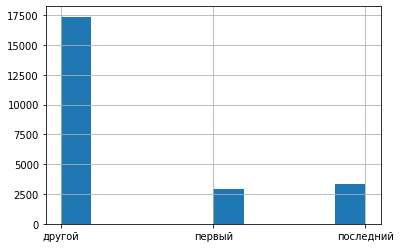

In [ ]:
data['floor_type'].hist()
plt.show()

**Вывод**  
Самый частный тип этажа - другой (около 17_500 квартир). Количество квартир на первом и последнем примерно похожее (порядка 2_500 - 3_000 квартир).

**floors_total**

count   23,613.00
mean        10.67
std          6.60
min          1.00
25%          5.00
50%          9.00
75%         16.00
max         60.00
Name: floors_total, dtype: float64
Количество пустых значений: 86


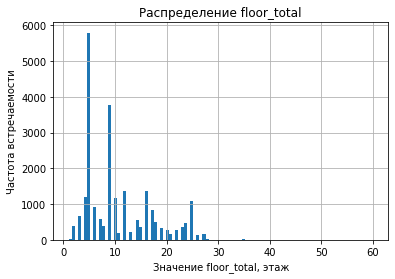

Квантили 25, 50, 75:
0.25    5.00
0.50    9.00
0.75   16.00
Name: floors_total, dtype: float64
Границы значений:
1.0 32.5


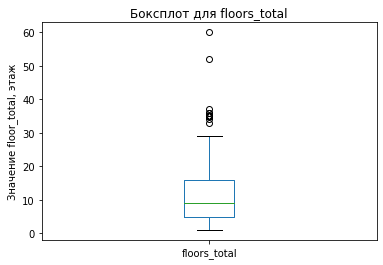

In [ ]:
# Выведем информацию
explore(
    data,
    column='floors_total',
    graph_name='Распределение floor_total',
    x_name='Значение floor_total, этаж',
    y_name='Частота встречаемости'
)

**Вывод**   
Основной диапазон для этажа - от 1 до 33. Пребладают 5-этажные дома (порядка 5_500 квартир), на втором месте - 9-этажные (порядка 3_500 квартир).

**cityCenters_nearest**

count   18,180.00
mean    14,191.28
std      8,608.39
min        181.00
25%      9,238.00
50%     13,098.50
75%     16,293.00
max     65,968.00
Name: cityCenters_nearest, dtype: float64
Количество пустых значений: 5519


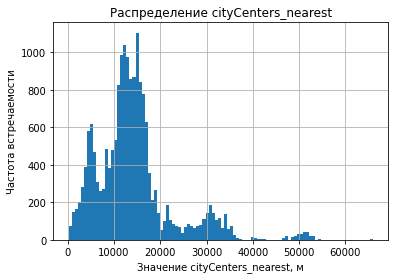

Квантили 25, 50, 75:
0.25    9,238.00
0.50   13,098.50
0.75   16,293.00
Name: cityCenters_nearest, dtype: float64
Границы значений:
181.0 26875.5


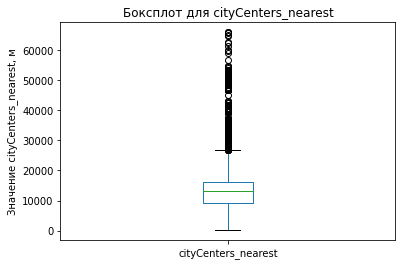

In [ ]:
# Выведем информацию
explore(
    data,
    column='cityCenters_nearest',
    graph_name='Распределение cityCenters_nearest',
    x_name='Значение cityCenters_nearest, м',
    y_name='Частота встречаемости'
)

category  близко  умеренно далеко  далеко  очень далеко
rooms                                                  
0             24               26      38            30
1            778             1588    1745          1777
2           1402             1584    1459          1481
3           1402             1111    1108          1078
4            559              193     160           146
5            225               23      35            18
6             86                6       3             7
7             54                0       0             3
8             11                0       0             1
9              3                4       0             1
10             2                1       0             0
11             2                0       0             0
12             1                0       0             0
14             2                0       0             0
15             1                0       0             0
16             1                0       0       

<Figure size 1080x720 with 0 Axes>

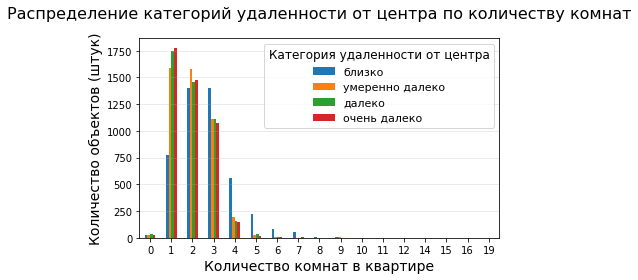

In [ ]:
# Выделим категории, работаем с копией датасета
cityCenters_nearest_cat_temp = data.copy()
bins = [0, 9238, 13098, 16293, float('inf')]
labels = ['близко', 'умеренно далеко', 'далеко', 'очень далеко']
cityCenters_nearest_cat_temp['category'] = pd.cut(cityCenters_nearest_cat_temp['cityCenters_nearest'], bins=bins, labels=labels)

graph_cityCenters_nearest = cityCenters_nearest_cat_temp.groupby(['rooms', 'category']).size().unstack()
print(graph_cityCenters_nearest)

plt.figure(figsize=(15, 10))
graph_cityCenters_nearest.plot(kind='bar', stacked=False)
plt.title('Распределение категорий удаленности от центра по количеству комнат', fontsize=16, pad=20)
plt.xlabel('Количество комнат в квартире', fontsize=14)
plt.ylabel('Количество объектов (штук)', fontsize=14)
plt.legend(title='Категория удаленности от центра', title_fontsize=12, fontsize=11)
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

**Вывод**  
1-комнатные квартиры в основном расположены далеко от центра (1_745 и 1_777 далеко и очень далеко соотвественно). У 2-комнатных квартир с небольшим отрывом преобладает умеренная удаленность от центра (1_584 квартир). 3-комнатные квартиры (1_402 квартир) и далее в основном близко расположены к центру .

**parks_nearest**

count   8,079.00
mean      490.80
std       342.32
min         1.00
25%       288.00
50%       455.00
75%       612.00
max     3,190.00
Name: parks_nearest, dtype: float64
Количество пустых значений: 15620


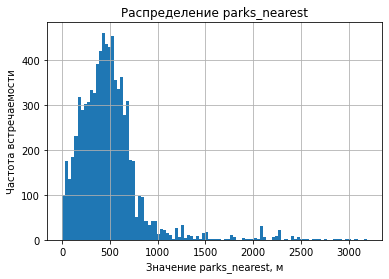

Квантили 25, 50, 75:
0.25   288.00
0.50   455.00
0.75   612.00
Name: parks_nearest, dtype: float64
Границы значений:
1.0 1098.0


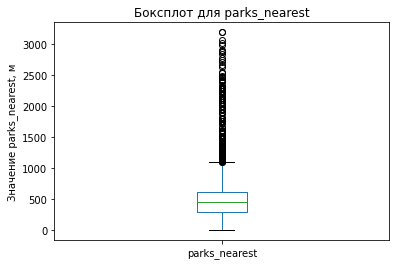

In [ ]:
# Выведем информацию
explore(
    data,
     column='parks_nearest',
    graph_name='Распределение parks_nearest',
    x_name='Значение parks_nearest, м',
    y_name='Частота встречаемости'
)

category  близко  умеренно далеко  далеко  очень далеко
rooms                                                  
0              5                3       9            12
1            574              567     516           621
2            651              658     699           667
3            560              523     568           556
4            158              147     144           114
5             61               64      37            33
6             22               23      20             3
7              7               15      12             4
8              4                0       5             2
9              2                5       1             0
10             1                2       0             0
11             0                0       0             1
12             0                0       0             0
14             0                0       1             0
15             0                0       0             1
16             0                0       1       

<Figure size 1080x720 with 0 Axes>

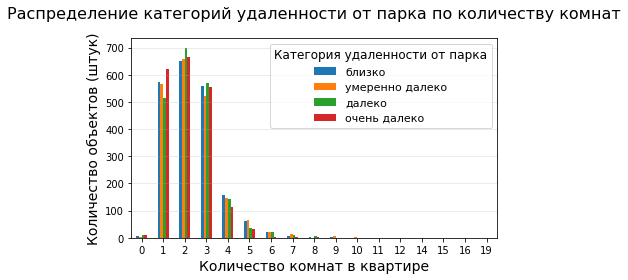

In [ ]:
# Выделим категории, работаем с копией датасета
parks_nearest_cat_temp = data.copy()
bins = [0, 288, 455, 612, float('inf')]
labels = ['близко', 'умеренно далеко', 'далеко', 'очень далеко']
parks_nearest_cat_temp['category'] = pd.cut(parks_nearest_cat_temp['parks_nearest'], bins=bins, labels=labels)

graph_parks_nearest = parks_nearest_cat_temp.groupby(['rooms', 'category']).size().unstack()
print(graph_parks_nearest)

plt.figure(figsize=(15, 10))
graph_parks_nearest.plot(kind='bar', stacked=False)
plt.title('Распределение категорий удаленности от парка по количеству комнат', fontsize=16, pad=20)
plt.xlabel('Количество комнат в квартире', fontsize=14)
plt.ylabel('Количество объектов (штук)', fontsize=14)
plt.legend(title='Категория удаленности от парка', title_fontsize=12, fontsize=11)
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

**Вывод**  
Для 1-комнатных квартир преобладает очень далекое располжение от парка (621 квартир), для 2-комнатных - далекое расположение от парка (699 квартиры), для 3-комнатных - представлены все 4 категории почти в ранвых количествах, далее преобладает близкое расположение к парку

**balcony**

In [ ]:
data['balcony'].value_counts()

0    15277
1     4195
2     3659
5      304
4      183
3       81
Name: balcony, dtype: int64

**Вывод**  
Будем считаться аномальным значением количетсво балконов = 5.

**Работа с аномалиями**

Сформируем отфильтрованный датасет с учетом тех границ, которые были определены ранее

In [ ]:
#Перечислим условия

total_area_cond = "22.25 <= total_area <= 155.85"

living_area_cond = "13.1 <= living_area <= 91.5"

kitchen_area_cond = "3.7 <= kitchen_area <= 25.8"

last_price_m_cond = "350_000.0 <= last_price <= 25_050_000.0"

floors_total_cond = "1 <= floors_total <= 35"

rooms_cond = "0 <= rooms <= 10"

balcony_cond = "0 <= balcony <= 4"

In [ ]:
# Создадим
data = data.query(total_area_cond + " and "
                         + living_area_cond + " and "
                         + kitchen_area_cond + " and "
                         + last_price_m_cond + " and "
                         + floors_total_cond + " and "
                         + rooms_cond + " and "
                         + balcony_cond
                         )

In [ ]:
# Удалим строки, где сумма площадей не корректна
data = data[
    (data[['living_area', 'kitchen_area', 'total_area']].isna().any(axis=1)) |
    (data['living_area'] + data['kitchen_area'] <= data['total_area'])
]

In [ ]:
print('🚨🚨🚨 ПРОВЕРКА. Смотри, сколько удалено % данных: ', (1 - (len(data) / 23699))* 100)

🚨🚨🚨 ПРОВЕРКА. Смотри, сколько удалено % данных:  9.321068399510523


**Вывод**: количество удаленных записей в пределах нормы: 9,3%.

**Изучениие days_exposition: как быстро продавались квартиры**

count   18,725.00
mean       178.12
std        216.38
min          1.00
25%         45.00
50%         94.00
75%        227.00
max      1,580.00
Name: days_exposition, dtype: float64
Количество пустых значений: 0


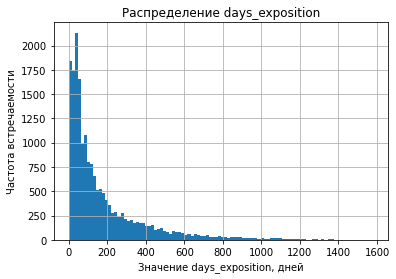

Квантили 25, 50, 75:
0.25    45.00
0.50    94.00
0.75   227.00
Name: days_exposition, dtype: float64
Границы значений:
1.0 500.0


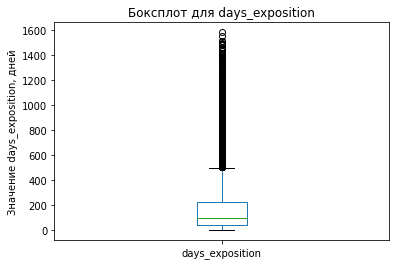

In [ ]:
explore(
    data[data['days_exposition'] != 0],
    column='days_exposition',
    graph_name='Распределение days_exposition',
    x_name='Значение days_exposition, дней',
    y_name='Частота встречаемости'
)

category  быстро  умеренное ожидание  среднее ожидание  долгое ожидание
rooms                                                                  
1           1946                1764              1611             1509
2           1651                1764              1673             1568
3            928                1023              1158             1282
4            131                 137               193              277
5             10                  15                32               41
6              1                   2                 2                4
7              0                   1                 2                0


<Figure size 1080x720 with 0 Axes>

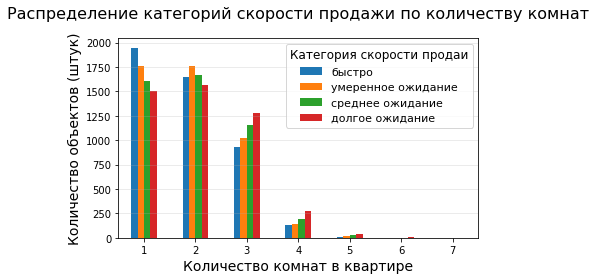

In [ ]:
# Посмотрим, как продавались квартиры с разным количеством комнат

days_exposition_cat_temp = data.copy()
bins = [0, 45, 94, 227, float('inf')]
labels = ['быстро', 'умеренное ожидание', 'среднее ожидание', 'долгое ожидание']
days_exposition_cat_temp['category'] = pd.cut(days_exposition_cat_temp['days_exposition'], bins=bins, labels=labels)
graph_days_exposition = days_exposition_cat_temp.groupby(['rooms', 'category']).size().unstack()
print(graph_days_exposition)
plt.figure(figsize=(15, 10))
graph_days_exposition.plot(kind='bar', stacked=False)
plt.title('Распределение категорий скорости продажи по количеству комнат', fontsize=16, pad=20)
plt.xlabel('Количество комнат в квартире', fontsize=14)
plt.ylabel('Количество объектов (штук)', fontsize=14)
plt.legend(title='Категория скорости продаи', title_fontsize=12, fontsize=11)
plt.grid(axis='y', alpha=0.3)  # сетка только по оси Y для лучшей читаемости
plt.xticks(rotation=0)  # горизонтальное расположение подписей по оси X
plt.tight_layout()  # оптимизируем отступы
plt.show()

category_de  быстро  умеренное ожидание  среднее ожидание  долгое ожидание
category                                                                  
эконом          915                1039               963              908
комфорт        1190                1075               957              932
бизнес         1075                1041              1035              921
премиум         949                 949               973              997
элитный         538                 602               743              923


<Figure size 4320x4320 with 0 Axes>

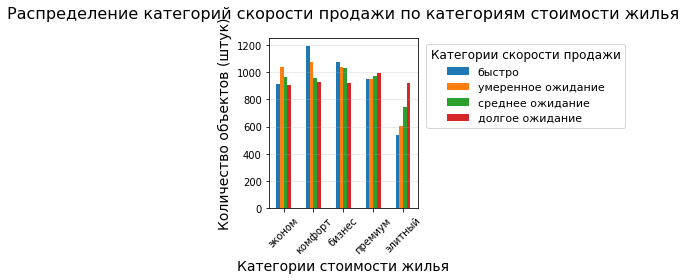

In [ ]:
# Посмотрим, как распределен срок ожидания в каждой категории стоимости жилья
last_price_cat_temp['category_de'] = pd.cut(days_exposition_cat_temp['days_exposition'], bins=bins, labels=labels)
graph_days_exposition = last_price_cat_temp.groupby(['category', 'category_de']).size().unstack()
print(graph_days_exposition)
plt.figure(figsize=(60, 60))
graph_days_exposition.plot(kind='bar', stacked=False)
plt.title('Распределение категорий скорости продажи по категориям стоимости жилья', fontsize=16, pad=20)
plt.xlabel('Категории стоимости жилья', fontsize=14)
plt.ylabel('Количество объектов (штук)', fontsize=14)
plt.legend(title='Категории скорости продажи',
            title_fontsize=12,
            fontsize=11,
            bbox_to_anchor=(1.02, 1),  # Позиция: чуть правее верхнего угла
            loc='upper left',             # Точка привязки легенды
            frameon=True,                # Рамка вокруг легенды
            fancybox=True,               # Скруглённые углы рамки
            shadow=False                   # Без тени (для лаконичности)
)
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.show()

**Вывод**  
Быстрее всего в основном продаются 1-комнатный квартиры (1_943 квартир были проданы в срок до 45 дней). Для 2-комнатных квартир  преобладает умеренный срок ожидания - 1_764 проданы в срок от 45 до 94 дней (небольшой отрыв от других категорий). Для 3-комнатных квартир и больше - долгое ожидание. Для класса жилья "премиум" срок ожидания может быть разным, явно выдающейся категории нет. Для класса "комфорт" лидирует категории с быстрой продажей - 1_190 квартир. Элитные квартиры продаются очень долго - 923 квартиры в категории "долгое ожидание" (от 227 дней).
Средняя длительность размещения объявления - 178 день, медианная длительность размещения объявления - 94 дня. Быстрой можно считать продажу до 45 дней (квантиль 25%), долгой - 227 дней (квантиль 75%) и более.

# <a id="section5"></a>4 Зависимость стоимости от разных факторов

In [ ]:
# Создадим функцию для вывода графиков
def scatter_graphs(data, column):
    plt.scatter(x=data[column], y=data['last_price'])
    x = data[column]
    y = data['last_price']
    m, b = np.polyfit(x, y, 1)
    plt.plot(x, m*x + b, color='black')
    plt.title(f'Зависимость цены от {column}')  # Заголовок графика
    plt.xlabel(f'{column}')  # Подпись оси X
    plt.ylabel('Цена (руб.)', fontsize=14)
    plt.show()

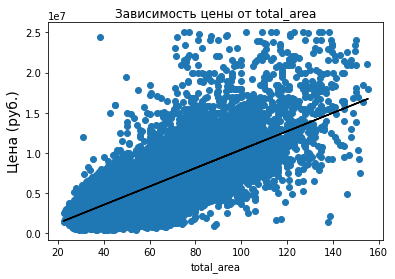

In [ ]:
#построим графики
scatter_graphs(data, 'total_area')

Оба параметра - количественные переменные. Они не распределены нормально, поэтому рассчитаем коэффициент корелляция Спирмена.

In [ ]:
#Рассчитаем коэффициент корреляции Спирмена
data['last_price'].corr(data['total_area'], method='spearman').round(2)

0.71

**Вывод**  
Анализ показывает наличие умеренной линейной связи между общей площадью и стоимостью квартиры: коэффициент корреляции Спирмена = 0.71.

**living_area**

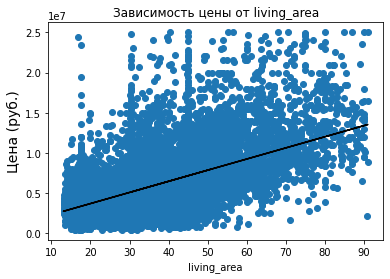

In [ ]:
#построим графики
scatter_graphs(data, 'living_area')

Оба параметра - количественные переменные. Они не распределены нормально, поэтому рассчитаем коэффициент корелляция Спирмена.

In [ ]:
data['last_price'].corr(data['living_area'], method='spearman').round(2)

0.58

**Вывод**  
Анализ показывает наличие умеренной линейной связи между жилой площадью и стоимостью квартиры: коэффициент корреляции Спирмена - 0.58

**kitchen_area**

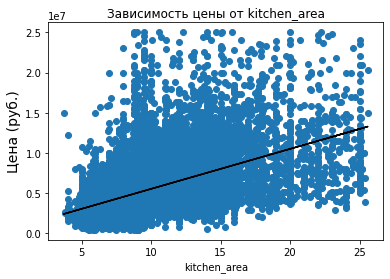

In [ ]:
#построим графики
scatter_graphs(data, 'kitchen_area')

Оба параметра - количественные переменные. Они не распределены нормально, поэтому рассчитаем коэффициент корелляция Спирмена.

In [ ]:
data['last_price'].corr(data['kitchen_area'], method='spearman').round(2)

0.51

**Вывод**  
Анализ показывает наличие умеренной линейной связи между площадью кухни и стоимостью квартиры: коэффициент корреляции Спирмена 0.51.

**rooms**

Количество комнат - категориальная переменная, они может принимать только целые значения.

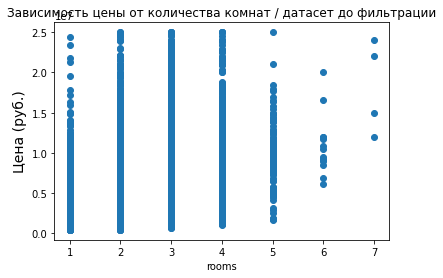

In [ ]:
#Посмотрим на скаттерограмму на основе датасета до фильтрации
plt.scatter(x=data['rooms'], y=data['last_price'])
plt.title('Зависимость цены от количества комнат / датасет до фильтрации')  # Заголовок графика
plt.xlabel('rooms')  # Подпись оси X
plt.ylabel('Цена (руб.)', fontsize=14)
plt.show()

Выглядит как-то хаотично

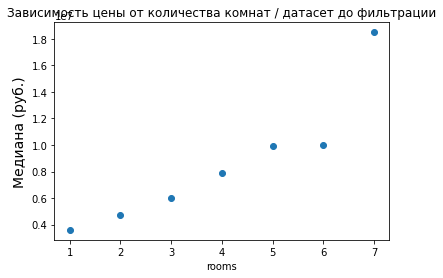

In [ ]:
#Раздлеим на группы и посчитаем медиану - статистику, устойчивую к выбросам
m_data = data.groupby(['rooms'])['last_price'].median().reset_index()
plt.scatter(x=m_data['rooms'], y=m_data['last_price'])
plt.title('Зависимость цены от количества комнат / датасет до фильтрации')  # Заголовок графика
plt.xlabel('rooms')  # Подпись оси X
plt.ylabel('Медиана (руб.)', fontsize=14)
plt.show()

Применим критерий Краскела-Уоллиса (так как одна переменная категориальная, данные не распределены номрально). Уровень значимости - 0.05

In [ ]:
# Создаем группы по количеству комнат
groups = {room: data[data['rooms'] == room]['last_price'] for room in data['rooms'].unique()}

# Проводим ANOVA тест
f_stat, p_value = stat, p_value = kruskal(*groups.values())
print(f"p-value = {p_value}")

# Интерпретация p-value:
if p_value < 0.05:
    print("Существует статистически значимая разница между группами")
else:
    print("Нет статистически значимой разницы между группами")

p-value = 0.0
Существует статистически значимая разница между группами


**Вывод**  
И график зависимости медианной цены от количества комнат, и критерий Краскела-Уоллиса говорят о наличии связи между количеством комнат и стоимости жилья.

**floor_type**

Выполняем тест Краскела-Уоллиса (так как тип этажа - категориальаня переменная, и цена жилья не распределена нормально)

In [ ]:
# Разделяем данные по типам этажей
first_floor = data[data['floor_type'] == 'первый']['last_price']
last_floor = data[data['floor_type'] == 'последний']['last_price']
other_floor = data[data['floor_type'] == 'другой']['last_price']

# Выполняем тест Краскела-Уоллиса, уровень значимости 0.05
H, p_value = kruskal(first_floor, last_floor, other_floor)

# Выводим результаты
print(f"Статистика H: {H:.4f}")
print(f"P-value: {p_value:.4f}")

# Интерпретация p-value:
if p_value < 0.05:
    print("Существует статистически значимая разница между группами")
else:
    print("Нет статистически значимой разницы между группами")

# Дополнительные метрики
print("\nСредние цены по типам этажей:")
print(data.groupby(['floor_type'])['last_price'].mean())

print("\nМедианные цены по типам этажей:")
print(data.groupby(['floor_type'])['last_price'].median())

Статистика H: 632.8446
P-value: 0.0000
Существует статистически значимая разница между группами

Средние цены по типам этажей:
floor_type
другой      5,609,446.17
первый      4,361,323.51
последний   4,956,126.52
Name: last_price, dtype: float64

Медианные цены по типам этажей:
floor_type
другой      4,745,500.00
первый      3,900,000.00
последний   4,150,000.00
Name: last_price, dtype: float64


**Вывод**  
Проведённый статистический анализ (критерий Краскела-Уоллиса) выявил статистически значимые различия в ценах на квартиры в зависимости от типа этажа (P-value = 0.0000, H = 633), при этом наблюдается тенденция: квартира на средних этажах имеет более высокую медианную и среднюю стоимость.

**Зависимость стоимости квартиры от даты размещения (день недели, месяц, год)**

**день недели**

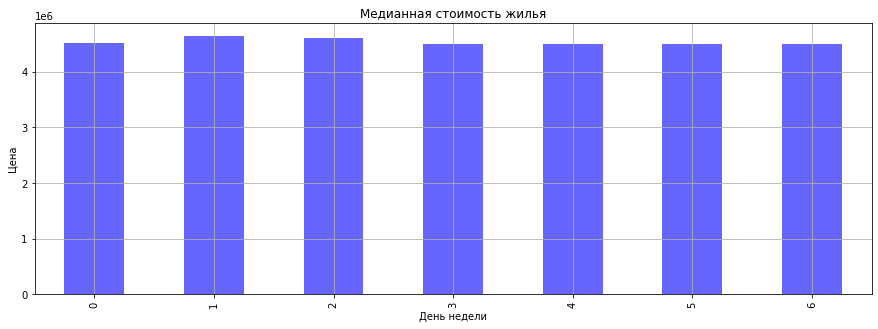

In [ ]:
# Посмотрим, как меняется медиана в зависимости от дня недели размещения объявления
(
    data
    .pivot_table(
        index='weekday_fd_exp',
        values='last_price',
        aggfunc='median'
    )
    .sort_index()
    .plot(
        y='last_price',
        kind='bar',
        figsize=(15, 5),
        legend=False,
        grid=True,
        color='blue',
        alpha=0.6
    )
)
plt.title('Медианная стоимость жилья')
plt.ylabel('Цена')
plt.xlabel('День недели')
plt.show()

Визуальной разницы нет. Проведем статистический тест.

In [ ]:
# Создаем группы
print("Уровень значимости: 0.05\n")
groups = {day: data[data['weekday_fd_exp'] == day]['last_price'] for day in data['weekday_fd_exp'].unique()}

# Критерий Краскела-Уоллиса
stat, p_value = kruskal(*groups.values())
print(f"Общий критерий Краскела-Уоллиса: p-value = {p_value}")

# Интерпретация p-value:
if p_value < 0.05:
    print("Существует статистически значимая разница между группами")
else:
    print("Нет статистически значимой разницы между группами")

# Подготовка данных для пост-хок анализа
mc = MultiComparison(
    data=data['last_price'],  # Зависимая переменная
    groups=data['weekday_fd_exp']  # Категориальная переменная
)

# Проведение попарных сравнений
result = mc.tukeyhsd()

# Вывод результатов
print("Результаты попарных сравнений:")
print(result)

Уровень значимости: 0.05

Общий критерий Краскела-Уоллиса: p-value = 0.037831383594634616
Существует статистически значимая разница между группами
Результаты попарных сравнений:
       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
group1 group2   meandiff   p-adj     lower        upper    reject
-----------------------------------------------------------------
     0      1   82157.8753 0.9358 -143393.2102 307708.9609  False
     0      2   81541.2431  0.941 -146448.2724 309530.7585  False
     0      3   64786.5448 0.9795  -159789.183 289362.2727  False
     0      4  -33523.0104 0.9995 -261008.8322 193962.8113  False
     0      5 -188521.7941 0.4204 -467730.2536  90686.6654  False
     0      6 -117906.9817 0.8977 -409763.8907 173949.9274  False
     1      2    -616.6323    1.0 -220144.2932 218911.0287  False
     1      3  -17371.3305    1.0 -233351.4969 198608.8359  False
     1      4 -115680.8858 0.7096 -334685.3923 103323.6207  False
     1      5 -270679.6694 0.0

**Вывод**  
По результатам анализа: общий тест Краскела‑Уоллиса выявил статистически значимую разницу (p‑value = 0,0378 < 0,05) в уровне цен на квартиры в зависимости от дня недели, когда было размещено объявление о продаже; однако попарные сравнения по методу Тьюки не обнаружили ни одной конкретной пары дней недели с значимыми различиями (все скорректированные p‑adj > 0,05, reject = False). Это означает, что точно указать, между какими именно днями недели есть ценовые различия, не удаётся — вероятно, из‑за распределения эффектов между несколькими группами, недостаточной мощности тестов или неоднородности данных в отдельных группах.

**месяц**

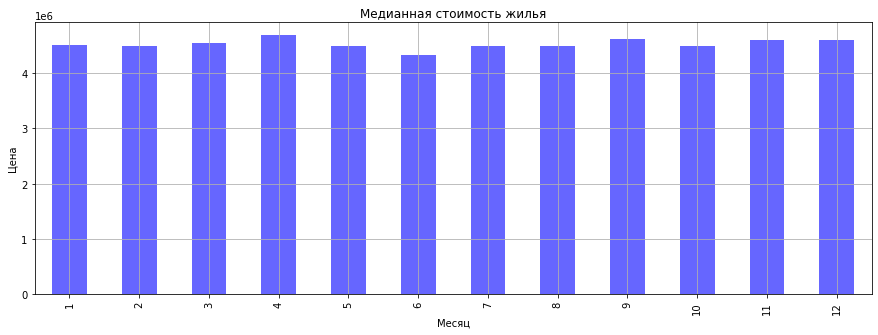

In [ ]:
# Посмотрим, как меняется медиана в зависимости от дня недели размещения объявления
(
    data
    .pivot_table(
        index='month_fd_exp',
        values='last_price',
        aggfunc='median'
    )
    .sort_index()
    .plot(
        y='last_price',
        kind='bar',
        figsize=(15, 5),
        legend=False,
        grid=True,
        color='blue',
        alpha=0.6
    )
)
plt.title('Медианная стоимость жилья')
plt.ylabel('Цена')
plt.xlabel('Месяц')
plt.show()

In [ ]:
# Проведем тест Краскела-Уоллиса
# Создаем группы
print("Уровень значимости: 0.05\n")
groups = {month: data[data['month_fd_exp'] == month]['last_price'] for month in data['month_fd_exp'].unique()}

# Критерий Краскела-Уоллиса
stat, p_value = kruskal(*groups.values())
print(f"Общий критерий Краскела-Уоллиса: p-value = {p_value}")

# Интерпретация p-value:
if p_value < 0.05:
    print("Существует статистически значимая разница между группами")
else:
    print("Нет статистически значимой разницы между группами")

# Подготовка данных для пост-хок анализа
mc = MultiComparison(
    data=data['last_price'],  # Зависимая переменная
    groups=data['month_fd_exp']  # Категориальная переменная
)

# Проведение попарных сравнений
result = mc.tukeyhsd()

# Вывод результатов
print("Результаты попарных сравнений:")
print(result)

Уровень значимости: 0.05

Общий критерий Краскела-Уоллиса: p-value = 0.017426828270373527
Существует статистически значимая разница между группами
Результаты попарных сравнений:
       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
group1 group2   meandiff   p-adj     lower        upper    reject
-----------------------------------------------------------------
     1      2 -129721.1291 0.9897 -485648.8762  226206.618  False
     1      3  -89724.0237 0.9996 -446660.0554  267212.008  False
     1      4    2684.6191    1.0 -360241.6295 365610.8676  False
     1      5 -136462.1084 0.9962 -556936.2574 284012.0407  False
     1      6 -238153.0794  0.681 -623806.1967 147500.0379  False
     1      7 -168771.0088 0.9626 -560918.4252 223376.4075  False
     1      8  -93558.5878 0.9998 -481266.9679 294149.7924  False
     1      9  141441.7024 0.9868 -234800.9739 517684.3787  False
     1     10  -82263.2067 0.9999 -452663.8712 288137.4579  False
     1     11  -39080.1717    

/opt/conda/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1151: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


**Вывод**  
По результатам анализа: общий тест Краскела‑Уоллиса выявил статистически значимую разницу (p‑value = 0,0174 < 0,05) в уровне цен на квартиры в зависимости от месяца размещения объявления. Однако попарные сравнения по методу Тьюки показали значимое различие только между месяцами 6 и 9 (p‑adj = 0,0269 < 0,05, reject = True): средняя цена в 9‑м месяце существенно выше, чем в 6‑м. Для всех остальных пар месяцев скорректированные p‑adj превышали уровень значимости 0,05 (reject = False), то есть статистически значимых различий между ними не обнаружено. Таким образом, хотя в целом месяц размещения объявления влияет на цену (по Краскелу‑Уоллису), единственное подтверждённое различие — между 6‑м и 9‑м месяцами.

**год**

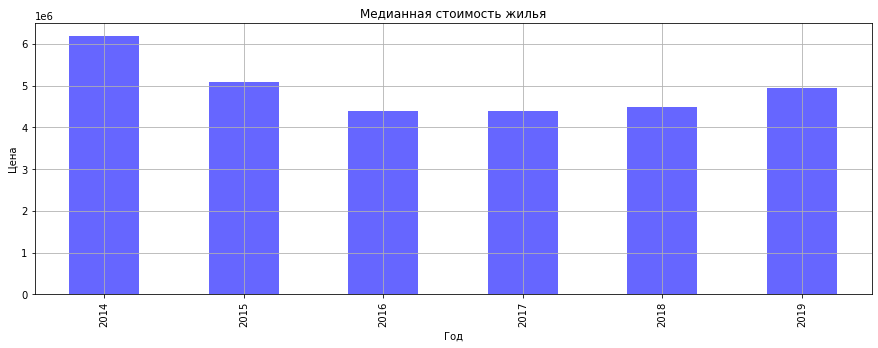

In [ ]:
# Посмотрим, как меняется медиана в зависимости от года размещения объявления
(
    data
    .pivot_table(
        index='year_fd_exp',
        values='last_price',
        aggfunc='median'
    )
    .sort_index()
    .plot(
        y='last_price',
        kind='bar',
        figsize=(15, 5),
        legend=False,
        grid=True,
        color='blue',
        alpha=0.6
    )
)
plt.title('Медианная стоимость жилья')
plt.ylabel('Цена')
plt.xlabel('Год')
plt.show()

In [ ]:
# Проведем тест Краскела-Уоллиса
# Создаем группы
print("Уровень значимости: 0.05\n")
groups = {year: data[data['year_fd_exp'] == year]['last_price'] for year in data['year_fd_exp'].unique()}

# Критерий Краскела-Уоллиса
stat, p_value = kruskal(*groups.values())
print(f"Общий критерий Краскела-Уоллиса: p-value = {p_value}")

# Интерпретация p-value:
if p_value < 0.05:
    print("Существует статистически значимая разница между группами")
else:
    print("Нет статистически значимой разницы между группами")

# Подготовка данных для пост-хок анализа
mc = MultiComparison(
    data=data['last_price'],  # Зависимая переменная
    groups=data['year_fd_exp']  # Категориальная переменная
)

# Проведение попарных сравнений
result = mc.tukeyhsd()

# Вывод результатов
print("Результаты попарных сравнений:")
print(result)

Уровень значимости: 0.05

Общий критерий Краскела-Уоллиса: p-value = 3.744034559565446e-31
Существует статистически значимая разница между группами
Результаты попарных сравнений:
         Multiple Comparison of Means - Tukey HSD, FWER=0.05         
group1 group2    meandiff   p-adj      lower         upper     reject
---------------------------------------------------------------------
  2014   2015 -1738873.8897    0.0 -2670466.9461  -807280.8333   True
  2014   2016 -2359691.9092    0.0 -3266114.7474  -1453269.071   True
  2014   2017 -2468354.1861    0.0 -3362741.9916 -1573966.3806   True
  2014   2018 -2497489.3145    0.0 -3391582.7547 -1603395.8742   True
  2014   2019 -2029305.2459    0.0 -2935083.6244 -1123526.8674   True
  2015   2016  -620818.0195    0.0  -955394.4825  -286241.5564   True
  2015   2017  -729480.2964    0.0 -1029927.6207  -429032.9721   True
  2015   2018  -758615.4247    0.0 -1058185.3297  -459045.5198   True
  2015   2019  -290431.3562 0.1279  -623257.9162   

**Вывод**  
По результатам анализа критерий Краскела‑Уоллиса выявил статистически значимую разницу между группами (по годам) в уровне цен (p‑value ≈ 3,74 × 10⁻³¹ < 0,05). Попарные сравнения по методу Тьюки показали, что значимо отличаются: 2014 от 2015, 2016, 2017, 2018 и 2019 гг.; 2015 от 2016, 2017 и 2018 гг.; 2016 от 2019 г.; 2017 и 2018 от 2019 г. При этом между 2016 и 2017, 2016 и 2018, 2017 и 2018 гг. различий не обнаружено (p‑adj > 0,05). Таким образом, цены систематически менялись от года к году, причём наиболее выраженные сдвиги пришлись на период с 2014 по 2019 г.

# <a id="section6"></a>5 Средняя цена одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений

In [ ]:
# Найдем Топ-10 по количеству объявлений
top_10 = (
        data
            .groupby(['locality_name'])
            .agg(cnt=('locality_name', 'count'))
            .sort_values(by='cnt', ascending=False)
            .head(10)
        )
top_10

,cnt
locality_name,
Санкт-Петербург,14017
Посёлок Мурино,505
Посёлок Шушары,412
Деревня Кудрово,411
Всеволожск,369
Пушкин,346
Колпино,324
Посёлок Парголово,305
Гатчина,293


In [ ]:
#Посчитаем среднюю цену одного кв. м.
(
    data
     .query('locality_name in @top_10.index')
     .groupby(['locality_name'])['sq.m. price']
     .mean()
     .reset_index()
     .sort_values(by='sq.m. price', ascending=False)
)

,locality_name,sq.m. price
9,Санкт-Петербург,"108,895.20"
8,Пушкин,"101,628.05"
3,Деревня Кудрово,"95,049.86"
6,Посёлок Парголово,"90,020.66"
5,Посёлок Мурино,"84,760.64"
7,Посёлок Шушары,"77,672.33"
4,Колпино,"75,237.65"
2,Гатчина,"68,732.19"
0,Всеволожск,"68,517.60"
1,Выборг,"57,574.72"


**Вывод**  
Самый выскоая стоимость за кв. м в Санкт-Петербурге: 108_895, самая низкая - в Выборге: 57_574.

**Средняя стоимость квартир в Санкт-Петербурге на каждом километре удаления от центра**

In [ ]:
#вытащим квартиры Санкт-Петерьурга из общего датасета
data_spb = data.query('locality_name == "Санкт-Петербург"')

In [ ]:
#Округлим до целого расстояние до центра (в км)
data_spb_grouped = data_spb
data_spb_grouped['cityCenters_nearest, km'] = round(data_spb_grouped['cityCenters_nearest, km'])
#Сгруппируем и посчитаем среднюю стоимость
data_spb_grouped_by_km = data_spb_grouped.groupby(['cityCenters_nearest, km'])['last_price'].mean().reset_index()

/tmp/ipykernel_463/1678026493.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_spb_grouped['cityCenters_nearest, km'] = round(data_spb_grouped['cityCenters_nearest, km'])


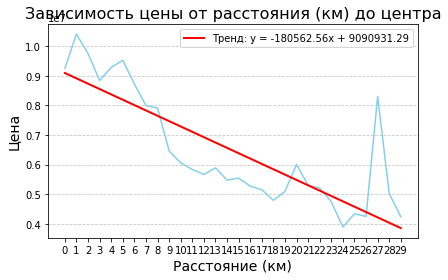

In [ ]:
bars = plt.plot(
    data_spb_grouped_by_km['cityCenters_nearest, km'],
    data_spb_grouped_by_km['last_price'],
    color='skyblue'
)
# Подготавливаем данные для линии тренда
x = data_spb_grouped_by_km['cityCenters_nearest, km'].values
y = data_spb_grouped_by_km['last_price'].values

# Вычисляем линию тренда
m, b = np.polyfit(x, y, 1)
trendline = m * x + b

# Добавляем линию тренда
plt.plot(
    x,
    trendline,
    color='red',
    linewidth=2,
    label=f'Тренд: y = {m:.2f}x + {b:.2f}'
)

# Добавляем украшения графика
plt.title('Зависимость цены от расстояния (км) до центра', fontsize=16)
plt.xlabel('Расстояние (км)', fontsize=14)
plt.ylabel('Цена', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.xticks(data_spb_grouped_by_km['cityCenters_nearest, km'])
plt.tight_layout()

plt.show()

**Вывод**  
На графике наблюдается тренд: чем дальше центр - тем ниже средняя стоимость жилья.

# <a id="section7"></a> Общий вывод

На основании анализа датасета с объявлениями о продаже квартир (исходно 23_699 записей, после очистки — 21_490) выявлены ключевые закономерности:   
1. Однокомнатные квартиры чаще относятся к сегментам «эконом» и «комфорт», двухкомнатные — к «бизнес» и «премиум», трёхкомнатные и более — к «элитному» классу.
2. Однокомнатные квартиры продаются быстрее (до 45 дней), трёхкомнатные — существенно дольше (от 227 дней).
3. Cтоимость жилья умеренно коррелирует с общей (r ≈ 0,71), жилой (r ≈ 0,58) и кухонной (r ≈ 0,41) площадями.
4. Наблюдается явная связь цены с числом комнат и типом этажа (статистически значимые различия по критерию Краскела‑Уоллиса, p = 0,0000), при этом квартиры на средних этажах дороже (медианная стоимость 4_745_500).
5. Самый выскоая стоимость за кв. м в Санкт-Петербурге: 108_895, самая низкая - в Выборге: 57_574.
6. Цена снижается с удалением от центра города.